# Big Data Coursework - Questions

## Data Processing and Machine Learning in the Cloud

This is the **INM432 Big Data coursework 2024**.
This coursework contains extended elements of **theory** and **practice**, mainly around parallelisation of tasks withSpark and a bit about parallel training using TensorFlow.   

## Code and Report

Your tasks parallelization of tasks in PySpark, extension, evaluation, and theoretical reflection.
Please complete and submit the **coding tasks** in a copy of **this notebook**.
Write your code in the **indicated cells** and **include** the **output** in the submitted notebook.  
Make sure that **your code contains comments** on its **stucture** and explanations of its **purpose**.

Provide also a **report** with the **textual answers in a separate document**.  
Include **screenshots** from the Google Cloud web interface (don't use the SCREENSHOT function that Google provides, but take a picture of the graphs you see for the VMs) and result tables, as well as written text about the analysis.



## Submission

Download and submit **your version of this notebook** as an **.ipynb** file and also submit a **shareable link** to your notebook on Colab in your report (created with the Colab 'Share' function) (**and don’t change the online version after submission**).

Further, provide your **report as a PDF document**. **State the number of words** in the document at the end. The report should **not have more than 2000 words**.  


Please also submit **a PDF of your Jupyter notebook**.

## Introduction and Description

This coursework focuses on parallelisation and scalability in the cloud with Spark and TesorFlow/Keras.
We start with code based on **lessons 3 and 4** of the [*Fast and Lean Data Science*](https://github.com/GoogleCloudPlatform/training-data-analyst/tree/master/courses/fast-and-lean-data-science) course by Martin Gorner.
The course is based on Tensorflow for data processing and MachineLearning.
Tensorflow's data processing approach is somewhat similar to that of Spark, but you don't need to study Tensorflow, just make sure you understand the high-level structure.  
What we will do here is **parallelising** **pre-processing**, and **measuring** performance, and we will perform **evaluation** and **analysis** on the cloud performance, as well as **theoretical discussion**.

This coursework contains **3 sections**.

### Section 0

This section just contains some necessary code for setting up the environment. It has no tasks for you (but do read the code and comments).

### Section 1
Section 1 is about preprocessing a set of image files.
We will work with a public dataset “Flowers” (3600 images, 5 classes).
This is not a vast dataset, but it keeps the tasks more manageable for development and you can scale up later, if you like.

In **'Getting Started'** we will work through the data preprocessing code from *Fast and Lean Data Science* which uses TensorFlow's `tf.data` package.
There is no task for you here, but you will need to re-use some of this code later.

In **Task 1** you will **parallelise the data preprocessing in Spark**, using Google Cloud (GC) Dataproc.
This involves adapting the code from 'Getting Started' to use Spark and running it in the cloud.

### Section 2
In **Section 2** we are going to **measure the speed of reading data** in the cloud. In **Task  2** we will **paralellize the measuring** of different configurations **using Spark**.

### Section 3

This section is about the theoretical discussion, based on one paper, in **Task 3**. The answers should be given in the PDF report.

### General points

For **all coding tasks**, take the **time of the operations** and for the cloud operations, get performance **information from the web interfaces** for your reporting and analysis.

The **tasks** are **mostly independent** of each other. The later tasks can mostly be addressed without needing the solution to the earlier ones.  

# Section 0: Set-up

As usual, you need to run the **imports and authentication every time you work with this notebook**. Use the **local Spark** installation for development before you send jobs to the cloud.

Read through this section once and **fill in the project ID the first time**, then you can just step straight throught this at the beginning of each session - except for the two authentication cells.

### Imports

We import some **packages that will be needed throughout**.
For the **code that runs in the cloud**, we will need **separate import sections** that will need to be partly different from the one below.


In [ ]:
import os, sys, math
import numpy as np
import scipy as sp
import scipy.stats
import time
import datetime
import string
import random
from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
import pickle

Tensorflow version 2.15.0


### Cloud and Drive authentication

This is for **authenticating with with GCS Google Drive**, so that we can create and use our own buckets and access Dataproc and AI-Platform.

This section **starts with the two interactive authentications**.

First, we mount Google Drive for persistent local storage and create a directory `DB-CW` thay you can use for this work.
Then we'll set up the cloud environment, including a storage bucket.

In [ ]:
print('Mounting google drive...')
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive"
!mkdir BD-CW
%cd "/content/drive/MyDrive/BD-CW"

Mounting google drive...
Mounted at /content/drive
/content/drive/MyDrive
mkdir: cannot create directory ‘BD-CW’: File exists
/content/drive/MyDrive/BD-CW


Next, we authenticate with the GCS to enable access to Dataproc and AI-Platform.

In [ ]:
import sys
if 'google.colab' in sys.modules:
    from google.colab import auth
    auth.authenticate_user()

It is useful to **create a new Google Cloud project** for this coursework. You can do this on the [GC Console page](https://console.cloud.google.com) by clicking on the entry at the top, right of the *Google Cloud Platform* and choosing *New Project*. **Copy** the **generated project ID** to the next cell. Also **enable billing** and the **Compute, Storage and Dataproc** APIs like we did during the labs.

We also specify the **default project and region**. The REGION should be `us-central1` as that seems to be the only one that reliably works with the free credit.
This way we don't have to specify this information every time we access the cloud.  

In [ ]:
PROJECT = 'big-data-coursework-420912'  ### USE YOUR GOOGLE CLOUD PROJECT ID HERE. ###
!gcloud config set project $PROJECT
REGION = 'us-central1'
CLUSTER = '{}-cluster'.format(PROJECT)
!gcloud config set compute/region $REGION
!gcloud config set dataproc/region $REGION

!gcloud config list # show some information

Updated property [core/project].
Updated property [compute/region].
Updated property [dataproc/region].
[component_manager]
disable_update_check = True
[compute]
region = us-central1
[core]
account = fasih.munir@city.ac.uk
project = big-data-coursework-420912
[dataproc]
region = us-central1

Your active configuration is: [default]


With the cell below, we **create a storage bucket** that we will use later for **global storage**.
If the bucket exists you will see a "ServiceException: 409 ...", which does not cause any problems.
**You must create your own bucket to have write access.**

In [ ]:
BUCKET = 'gs://{}-storage'.format(PROJECT)
!gsutil mb $BUCKET

Creating gs://big-data-coursework-420912-storage/...
ServiceException: 409 A Cloud Storage bucket named 'big-data-coursework-420912-storage' already exists. Try another name. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.


The cell below just **defines some routines for displaying images** that will be **used later**. You can see the code by double-clicking, but you don't need to study this.

In [ ]:
#@title Utility functions for image display **[RUN THIS TO ACTIVATE]** { display-mode: "form" }
def display_9_images_from_dataset(dataset):
  plt.figure(figsize=(13,13))
  subplot=331
  for i, (image, label) in enumerate(dataset):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image.numpy().astype(np.uint8))
    plt.title(str(label.numpy()), fontsize=16)
    # plt.title(label.numpy().decode(), fontsize=16)
    subplot += 1
    if i==8:
      break
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

def dataset_to_numpy_util(dataset, N):
    dataset = dataset.batch(N)
    for images, labels in dataset:
        numpy_images = images.numpy()
        numpy_labels = labels.numpy()
        break;
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
  correct = (label == correct_label)
  return "{} [{}{}{}]".format(CLASSES[label], str(correct), ', shoud be ' if not correct else '',
                              CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot+1

def display_9_images_with_predictions(images, predictions, labels):
  subplot=331
  plt.figure(figsize=(13,13))
  classes = np.argmax(predictions, axis=-1)
  for i, image in enumerate(images):
    title, correct = title_from_label_and_target(classes[i], labels[i])
    subplot = display_one_flower(image, title, subplot, not correct)
    if i >= 8:
      break;

  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()


### Install Spark locally for quick testing

You can use the cell below to **install Spark locally on this Colab VM** (like in the labs), to do quicker small-scale interactive testing. Using Spark in the cloud with **Dataproc is still required for the final version**.


In [ ]:

%cd
!apt-get update -qq
!apt-get install openjdk-8-jdk-headless -qq >> /dev/null # send any output to null device
!tar -xzf "/content/drive/My Drive/Big_Data/data/spark/spark-3.5.0-bin-hadoop3.tgz" # unpack

!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/root/spark-3.5.0-bin-hadoop3"
import findspark
findspark.init()
import pyspark
print(pyspark.__version__)
sc = pyspark.SparkContext.getOrCreate()
print(sc)

/root
3.5.0


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


<SparkContext master=local[*] appName=pyspark-shell>


# Section 1: Data pre-processing

This section is about the **pre-processing of a dataset** for deep learning.
We first look at a ready-made solution using Tensorflow and then we build a implement the same process with Spark.
The tasks are about **parallelisation** and **analysis** the performance of the cloud implementations.

## 1.1 Getting started

In this section, we get started with the data pre-processing. The code is based on lecture 3 of the 'Fast and Lean Data Science' course.

**This code is using the TensorFlow** `tf.data` package, which supports map functions, similar to Spark. Your **task** will be to **re-implement the same approach in Spark**.  


We start by **setting some variables for the *Flowers* dataset**.

In [ ]:
GCS_PATTERN = 'gs://flowers-public/*/*.jpg' # glob  pattern for input files
PARTITIONS = 16 # no of partitions we will use later
TARGET_SIZE = [192, 192] # target resolution for the images
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips']
    # labels for the data

We **read the image files** from the public GCS bucket that contains the *Flowers* dataset.
**TensorFlow** has **functions** to execute glob patterns that we use to calculate the the number of images in total and per partition (rounded up as we cannont deal with parts of images).

In [ ]:
nb_images = len(tf.io.gfile.glob(GCS_PATTERN)) # number of images
partition_size = math.ceil(1.0 * nb_images / PARTITIONS) # images per partition (float)
print("GCS_PATTERN matches {} images, to be divided into {} partitions with up to {} images each.".format(nb_images, PARTITIONS, partition_size))


GCS_PATTERN matches 3670 images, to be divided into 16 partitions with up to 230 images each.


### Map functions

In order to read use the images for learning, they need to be **preprocessed** (decoded, resized, cropped, and potentially recompressed).
Below are **map functions** for these steps.
You **don't need to study** the **internals of these functions** in detail.

In [ ]:
def decode_jpeg_and_label(filepath):
    # extracts the image data and creates a class label, based on the filepath
    bits = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(bits)
    # parse flower name from containing directory
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')
    label2 = label.values[-2]
    return image, label2

def resize_and_crop_image(image, label):
    # Resizes and cropd using "fill" algorithm:
    # always make sure the resulting image is cut out from the source image
    # so that it fills the TARGET_SIZE entirely with no black bars
    # and a preserved aspect ratio.
    w = tf.shape(image)[0]
    h = tf.shape(image)[1]
    tw = TARGET_SIZE[1]
    th = TARGET_SIZE[0]
    resize_crit = (w * th) / (h * tw)
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                    lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                    )
    nw = tf.shape(image)[0]
    nh = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
    return image, label

def recompress_image(image, label):
    # this reduces the amount of data, but takes some time
    image = tf.cast(image, tf.uint8)
    image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
    return image, label

With `tf.data`, we can apply decoding and resizing as map functions.

In [ ]:
dsetFiles = tf.data.Dataset.list_files(GCS_PATTERN) # This also shuffles the images
dsetDecoded = dsetFiles.map(decode_jpeg_and_label)
dsetResized = dsetDecoded.map(resize_and_crop_image)

We can also look at some images using the image display function defined above (the one with the hidden code).

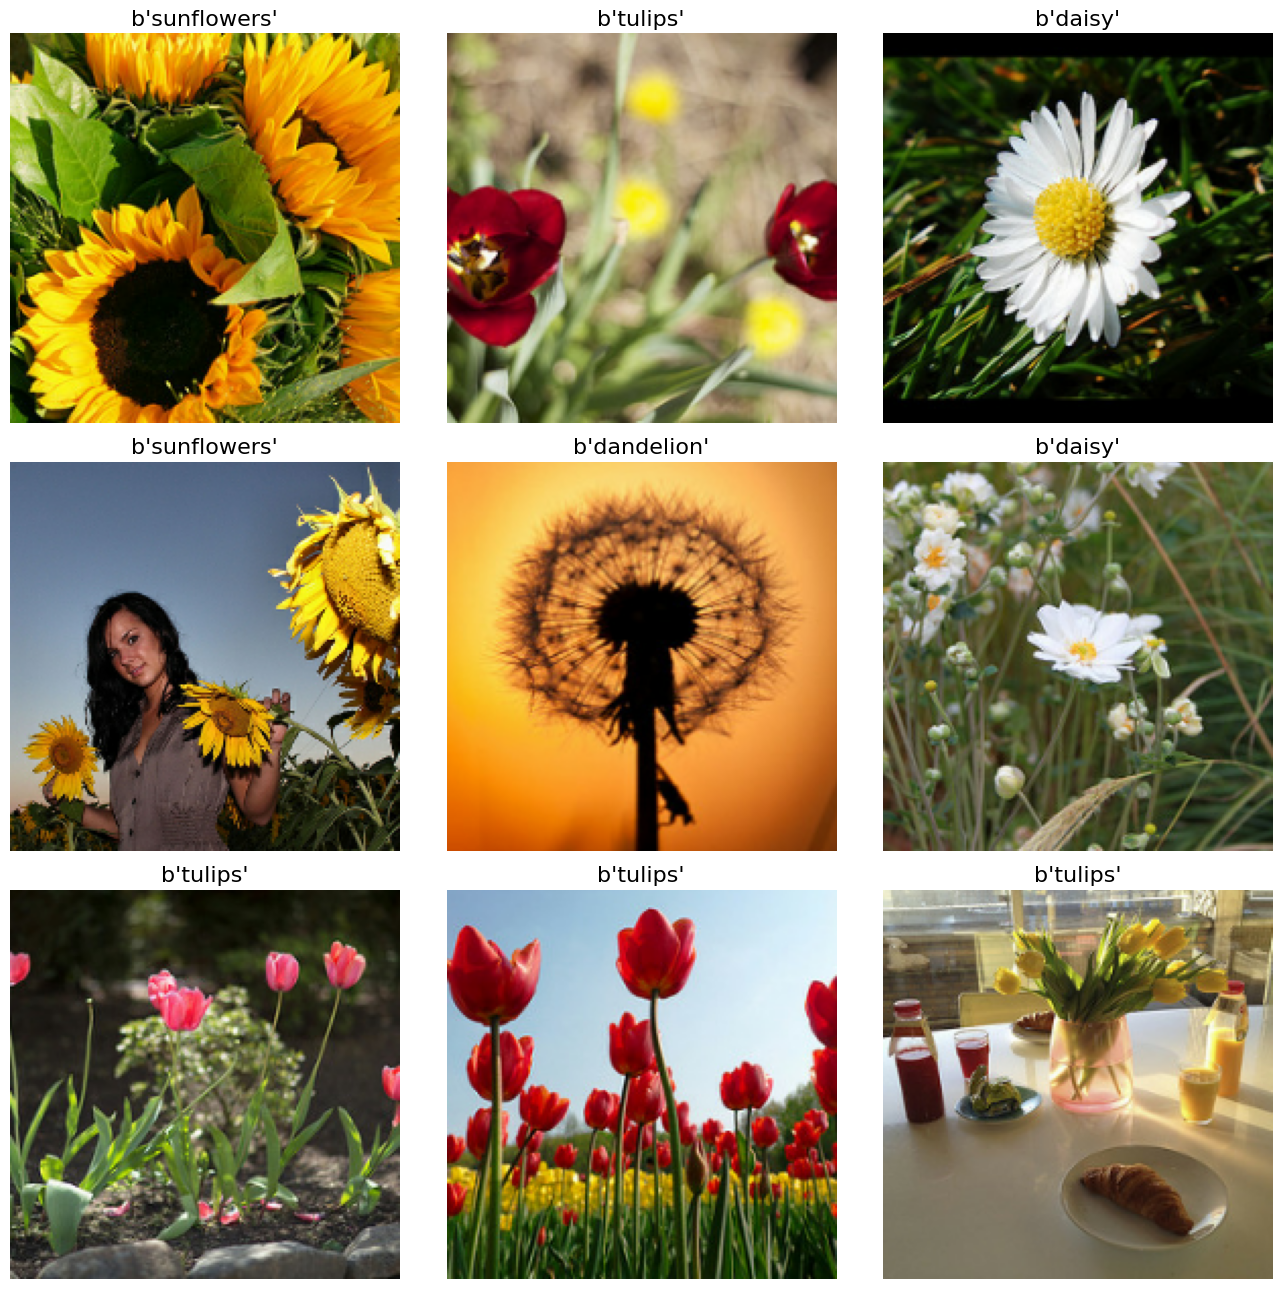

In [ ]:
display_9_images_from_dataset(dsetResized)

Now, let's test continuous reading from the dataset. We can see that reading the first 100 files already takes some time.

In [ ]:
sample_set = dsetResized.batch(10).take(10) # take 10 batches of 10 images for testing
for image, label in sample_set:
    print("Image batch shape {}, {})".format(image.numpy().shape,
        [lbl.decode('utf8') for lbl in label.numpy()]))

Image batch shape (10, 192, 192, 3), ['roses', 'roses', 'daisy', 'tulips', 'tulips', 'sunflowers', 'dandelion', 'daisy', 'roses', 'sunflowers'])
Image batch shape (10, 192, 192, 3), ['dandelion', 'sunflowers', 'roses', 'roses', 'sunflowers', 'sunflowers', 'tulips', 'daisy', 'tulips', 'roses'])
Image batch shape (10, 192, 192, 3), ['dandelion', 'sunflowers', 'dandelion', 'daisy', 'dandelion', 'sunflowers', 'roses', 'roses', 'dandelion', 'dandelion'])
Image batch shape (10, 192, 192, 3), ['tulips', 'roses', 'tulips', 'dandelion', 'roses', 'dandelion', 'tulips', 'roses', 'daisy', 'tulips'])
Image batch shape (10, 192, 192, 3), ['roses', 'tulips', 'sunflowers', 'dandelion', 'sunflowers', 'sunflowers', 'dandelion', 'dandelion', 'sunflowers', 'dandelion'])
Image batch shape (10, 192, 192, 3), ['sunflowers', 'dandelion', 'roses', 'dandelion', 'sunflowers', 'dandelion', 'tulips', 'sunflowers', 'tulips', 'sunflowers'])
Image batch shape (10, 192, 192, 3), ['tulips', 'dandelion', 'tulips', 'tuli

## 1.2 Improving Speed

Using individual image files didn't look very fast. The 'Lean and Fast Data Science' course introduced **two techniques to improve the speed**.


### Recompress the images
By **compressing** the images in the **reduced resolution** we save on the size.
This **costs some CPU time** upfront, but **saves network and disk bandwith**, especially when the data are **read multiple times**.


In [ ]:
# This is a quick test to get an idea how long recompressions takes.
dataset4 = dsetResized.map(recompress_image)
test_set = dataset4.batch(10).take(10)
for image, label in test_set:
    print("Image batch shape {}, {})".format(image.numpy().shape, [lbl.decode('utf8') for lbl in label.numpy()]))

Image batch shape (10,), ['roses', 'sunflowers', 'tulips', 'daisy', 'daisy', 'daisy', 'tulips', 'sunflowers', 'sunflowers', 'tulips'])
Image batch shape (10,), ['roses', 'dandelion', 'dandelion', 'dandelion', 'dandelion', 'dandelion', 'daisy', 'sunflowers', 'daisy', 'sunflowers'])
Image batch shape (10,), ['dandelion', 'roses', 'tulips', 'roses', 'daisy', 'dandelion', 'daisy', 'dandelion', 'roses', 'dandelion'])
Image batch shape (10,), ['sunflowers', 'sunflowers', 'tulips', 'roses', 'dandelion', 'dandelion', 'dandelion', 'sunflowers', 'sunflowers', 'roses'])
Image batch shape (10,), ['roses', 'dandelion', 'tulips', 'sunflowers', 'dandelion', 'dandelion', 'sunflowers', 'roses', 'daisy', 'tulips'])
Image batch shape (10,), ['tulips', 'daisy', 'sunflowers', 'tulips', 'daisy', 'dandelion', 'daisy', 'roses', 'tulips', 'roses'])
Image batch shape (10,), ['daisy', 'tulips', 'tulips', 'roses', 'tulips', 'sunflowers', 'tulips', 'daisy', 'sunflowers', 'tulips'])
Image batch shape (10,), ['tulip

### Write the dataset to TFRecord files

By writing **multiple preprocessed samples into a single file**, we can make further speed gains.
We distribute the data over **partitions** to facilitate **parallelisation** when the data are used.
First we need to **define a location** where we want to put the file.

In [ ]:
GCS_OUTPUT = BUCKET + '/tfrecords-jpeg-192x192-2/flowers'  # prefix for output file names

Now we can **write the TFRecord files** to the bucket.

Running the cell takes some time and **only needs to be done once** or not at all, as you can use the publicly available data for the next few cells. For convenience I have commented out the call to `write_tfrecords` at the end of the next cell. You don't need to run it (it takes some time), but you'll need to use the code below later (but there is no need to study it in detail).

There is a **ready-made pre-processed data** versions available here:
`gs://flowers-public/tfrecords-jpeg-192x192-2/`, that we can use for testing.

In [ ]:
# functions for writing TFRecord entries
# Feature values are always stored as lists, a single data element will be a list of size 1
def _bytestring_feature(list_of_bytestrings):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=list_of_bytestrings))

def _int_feature(list_of_ints): # int64
    return tf.train.Feature(int64_list=tf.train.Int64List(value=list_of_ints))

def to_tfrecord(tfrec_filewriter, img_bytes, label): # Create tf data records
    class_num = np.argmax(np.array(CLASSES)==label) # 'roses' => 2 (order defined in CLASSES)
    one_hot_class = np.eye(len(CLASSES))[class_num]     # [0, 0, 1, 0, 0] for class #2, roses
    feature = {
        "image": _bytestring_feature([img_bytes]), # one image in the list
        "class": _int_feature([class_num]) #,      # one class in the list
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

def write_tfrecords(GCS_PATTERN,GCS_OUTPUT,partition_size): # write the images to files.
    print("Writing TFRecords")
    tt0 = time.time()
    filenames = tf.data.Dataset.list_files(GCS_PATTERN)
    dataset1 = filenames.map(decode_jpeg_and_label)
    dataset2 = dataset1.map(resize_and_crop_image)
    dataset3 = dataset2.map(recompress_image)
    dataset4 = dataset3.batch(partition_size) # partitioning: there will be one "batch" of images per file
    for partition, (image, label) in enumerate(dataset4):
        # batch size used as partition size here
        partition_size = image.numpy().shape[0]
        # good practice to have the number of records in the filename
        filename = GCS_OUTPUT + "{:02d}-{}.tfrec".format(partition, partition_size)
        # You need to change GCS_OUTPUT to your own bucket to actually create new files
        with tf.io.TFRecordWriter(filename) as out_file:
            for i in range(partition_size):
                example = to_tfrecord(out_file,
                                    image.numpy()[i], # re-compressed image: already a byte string
                                    label.numpy()[i] #
                                    )
                out_file.write(example.SerializeToString())
        print("Wrote file {} containing {} records".format(filename, partition_size))
    print("Total time: "+str(time.time()-tt0))

#write_tfrecords(GCS_PATTERN,GCS_OUTPUT,partition_size) # uncomment to run this cell

### Test the TFRecord files

We can now **read from the TFRecord files**. By default, we use the files in the public bucket. Comment out the 1st line of the cell below to use the files written in the cell above.

In [ ]:
#GCS_OUTPUT = 'gs://flowers-public/tfrecords-jpeg-192x192-2/'
# remove the line above to use your own files that you generated above

def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])
    class_num = example['class']
    return image, class_num

def load_dataset(filenames):
    # read from TFRecords. For optimal performance, read from multiple
    # TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord)
    return dataset


filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")
datasetTfrec = load_dataset(filenames)

Let's have a look **if reading from the TFRecord** files is **quicker**.

In [ ]:
batched_dataset = datasetTfrec.batch(10)
sample_set = batched_dataset.take(10)
for image, label in sample_set:
    print("Image batch shape {}, {})".format(image.numpy().shape, \
                        [str(lbl) for lbl in label.numpy()]))

Image batch shape (10, 192, 192, 3), ['4', '3', '3', '2', '1', '0', '4', '4', '2', '3'])
Image batch shape (10, 192, 192, 3), ['1', '4', '1', '4', '0', '4', '1', '1', '0', '3'])
Image batch shape (10, 192, 192, 3), ['0', '2', '1', '1', '4', '1', '4', '2', '1', '1'])
Image batch shape (10, 192, 192, 3), ['1', '2', '3', '3', '1', '2', '4', '1', '0', '2'])
Image batch shape (10, 192, 192, 3), ['2', '1', '1', '2', '2', '2', '3', '4', '0', '0'])
Image batch shape (10, 192, 192, 3), ['1', '3', '0', '4', '3', '3', '0', '1', '3', '3'])
Image batch shape (10, 192, 192, 3), ['1', '1', '4', '4', '0', '4', '1', '0', '4', '4'])
Image batch shape (10, 192, 192, 3), ['0', '3', '3', '1', '2', '4', '4', '4', '2', '0'])
Image batch shape (10, 192, 192, 3), ['2', '1', '2', '4', '2', '4', '4', '0', '1', '1'])
Image batch shape (10, 192, 192, 3), ['4', '3', '1', '0', '2', '3', '2', '4', '1', '4'])


Wow, we have a **massive speed-up**! The repackageing is worthwhile :-)

## Task 1: Write TFRecord files to the cloud with Spark (40%)

Since recompressing and repackaging is very effective, we would like to be able to do it inparallel for large datasets.
This is a relatively straightforward case of **parallelisation**.
We will **use Spark to implement** the same process as above, but in parallel.

### 1a)	Create the script (14%)

**Re-implement** the pre-processing in Spark, using Spark mechanisms for **distributing** the workload **over multiple machines**.

You need to:

i) **Copy** over the **mapping functions** (see section 1.1) and **adapt** the resizing and recompression functions **to Spark** (only one argument). (3%)

ii) **Replace** the TensorFlow **Dataset objects with RDDs**, starting with an RDD that contains the list of image filenames. (3%)

iii) **Sample** the the RDD to a smaller number at an appropriate position in the code. Specify a sampling factor of 0.02 for short tests. (1%)

iv) Then **use the functions from above** to write the TFRecord files. (3%)

v) The code for **writing to the TFRecord files** needs to be put into a function, that can be applied to every partition with the ['RDD.mapPartitionsWithIndex'](https://spark.apache.org/docs/2.4.8/api/python/pyspark.html#pyspark.RDD.mapPartitionsWithIndex) function.
The return value of that function is not used here, but you should return the filename, so that you have a list of the created TFRecord files. (4%)


In [ ]:
### CODING TASK 1a.i ###

def resize_and_crop_image(image_data): #adapted to use 1 argument
    image, label = image_data #adapted to use 1 argument
    w = tf.shape(image)[0]
    h = tf.shape(image)[1]
    tw = TARGET_SIZE[1]
    th = TARGET_SIZE[0]
    resize_crit = (w * th) / (h * tw)
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [w*tw/w, h*tw/w]),
                    lambda: tf.image.resize(image, [w*th/h, h*th/h])
                    )
    nw = tf.shape(image)[0]
    nh = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
    return (image, label)

def recompress_image(image_data): #adapted to use 1 argument
    image, label = image_data #adapted to use 1 argument
    image = tf.cast(image, tf.uint8)
    image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
    return (image, label)

In [ ]:
### CODING TASK 1a.ii ###

#creating RDDs that replace the tensorflow dataset objects

#getting our list of files
#documentation: https://www.tensorflow.org/api_docs/python/tf/io/gfile/glob
#documentation: also the FAQ on Moodle
#allows to generalize tensorflow pipelines to work with things like spark and GCP more easily
filenames_spark = tf.io.gfile.glob(GCS_PATTERN)

#file RDD
#documentation: https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.SparkContext.parallelize.html
#distributes general list over nodes
rdd_filenames_spark = sc.parallelize(filenames_spark)

#creating RDDs for the other objects - decode, resize, recompress
#using map
#applys functions to each element in an RDD
#since we adapted the functions to use one argument we can simply use map
#documentation: https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.map.html
rdd_decode_jpeg_and_label = rdd_filenames_spark.map(decode_jpeg_and_label)
rdd_resize_and_crop_image = rdd_decode_jpeg_and_label.map(resize_and_crop_image)
rdd_recompress_image = rdd_resize_and_crop_image.map(recompress_image)

In [ ]:
### CODING TASK 1a.iii ###

#sampling the filenames RDD
#not replacing to avoid duplication
#no random seed - no indication given in instructions for reproducability
#documentation: https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.sample.html
rdd_filenames_sample_spark = rdd_filenames_spark.sample(False, 0.02)

In [ ]:
### CODING TASK 1a.iv ###

#writing tfrecord files
#removing decode, resize, recompress and partition from write function
#handled by the rdds above and the ones created in the next cell
#creating a file with the partition index and writing the file ie storing it
#creating a loop for every image and label in the partition/iteration
#could not think of a better name for iteration
#"serializing" or converting data into binary output for easy storage
#documentation: https://www.tensorflow.org/tutorials/load_data/tfrecord

#had to add the explicit .numpy cast as i was running into "type error"
#should have caught this earlier since the example code above was passing a tensor while this required a more normal data type

#also likely using enumerate could have worked as well rather than setting up a count although enumerate would have indexed so would have to add 1?

def write_tfrecords_updated(partition_index, iteration):
    tt0 = time.time()

    filename = GCS_OUTPUT + "/partition-{:02d}.tfrec".format(partition_index) #should have been partition but ran it as part now i cant change it
    with tf.io.TFRecordWriter(filename) as out_file:
        count = 0
        for image, label in iteration:
            example = to_tfrecord(out_file, image.numpy(), label.numpy())
            out_file.write(example.SerializeToString())
            count += 1

    tt1 = time.time() - tt0
    message = f"Wrote file {filename} containing {count} records in {tt1:.2f} seconds"

    return [(filename, message)]

In [ ]:
### CODING TASK 1a.v ###

#creating separate and new partitions and then running partition with index to maintain the index
#documentation on partitions: https://sparktpoint.com/spark-repartition-vs-coalesce/
#documentation: https://api-docs.databricks.com/python/pyspark/latest/api/pyspark.RDDBarrier.mapPartitionsWithIndex.html

rdd_partitioning = rdd_recompress_image.repartition(PARTITIONS)
rdd_partitioned_filenames = rdd_partitioning.mapPartitionsWithIndex(write_tfrecords_updated)

In [ ]:
#just checking to see if the above worked
#documentation: https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.take.html#pyspark.RDD.take

rdd_partitioned_filenames.take(3)
#rdd_partitioned_filenames

#wanted to see the print messages but wasnt able to get them to show so wrote a small loop to test
#but this loop is not needed as it simply works with take as returning the tuple in the function returns the message as well
#realized this after writing the loop
#documentation: https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.collect.html
#x = rdd_partitioned_filenames.collect()
#for message in x:
#  print(message)

[('gs://big-data-coursework-420912-storage/tfrecords-jpeg-192x192-2/flowers/partition-00.tfrec',
  'Wrote file gs://big-data-coursework-420912-storage/tfrecords-jpeg-192x192-2/flowers/partition-00.tfrec containing 228 records in 2.07 seconds'),
 ('gs://big-data-coursework-420912-storage/tfrecords-jpeg-192x192-2/flowers/partition-01.tfrec',
  'Wrote file gs://big-data-coursework-420912-storage/tfrecords-jpeg-192x192-2/flowers/partition-01.tfrec containing 220 records in 2.32 seconds'),
 ('gs://big-data-coursework-420912-storage/tfrecords-jpeg-192x192-2/flowers/partition-02.tfrec',
  'Wrote file gs://big-data-coursework-420912-storage/tfrecords-jpeg-192x192-2/flowers/partition-02.tfrec containing 220 records in 2.11 seconds')]

### 1b)	Testing (3%)

i) Read from the TFRecord Dataset, using `load_dataset` and `display_9_images_from_dataset` to test.


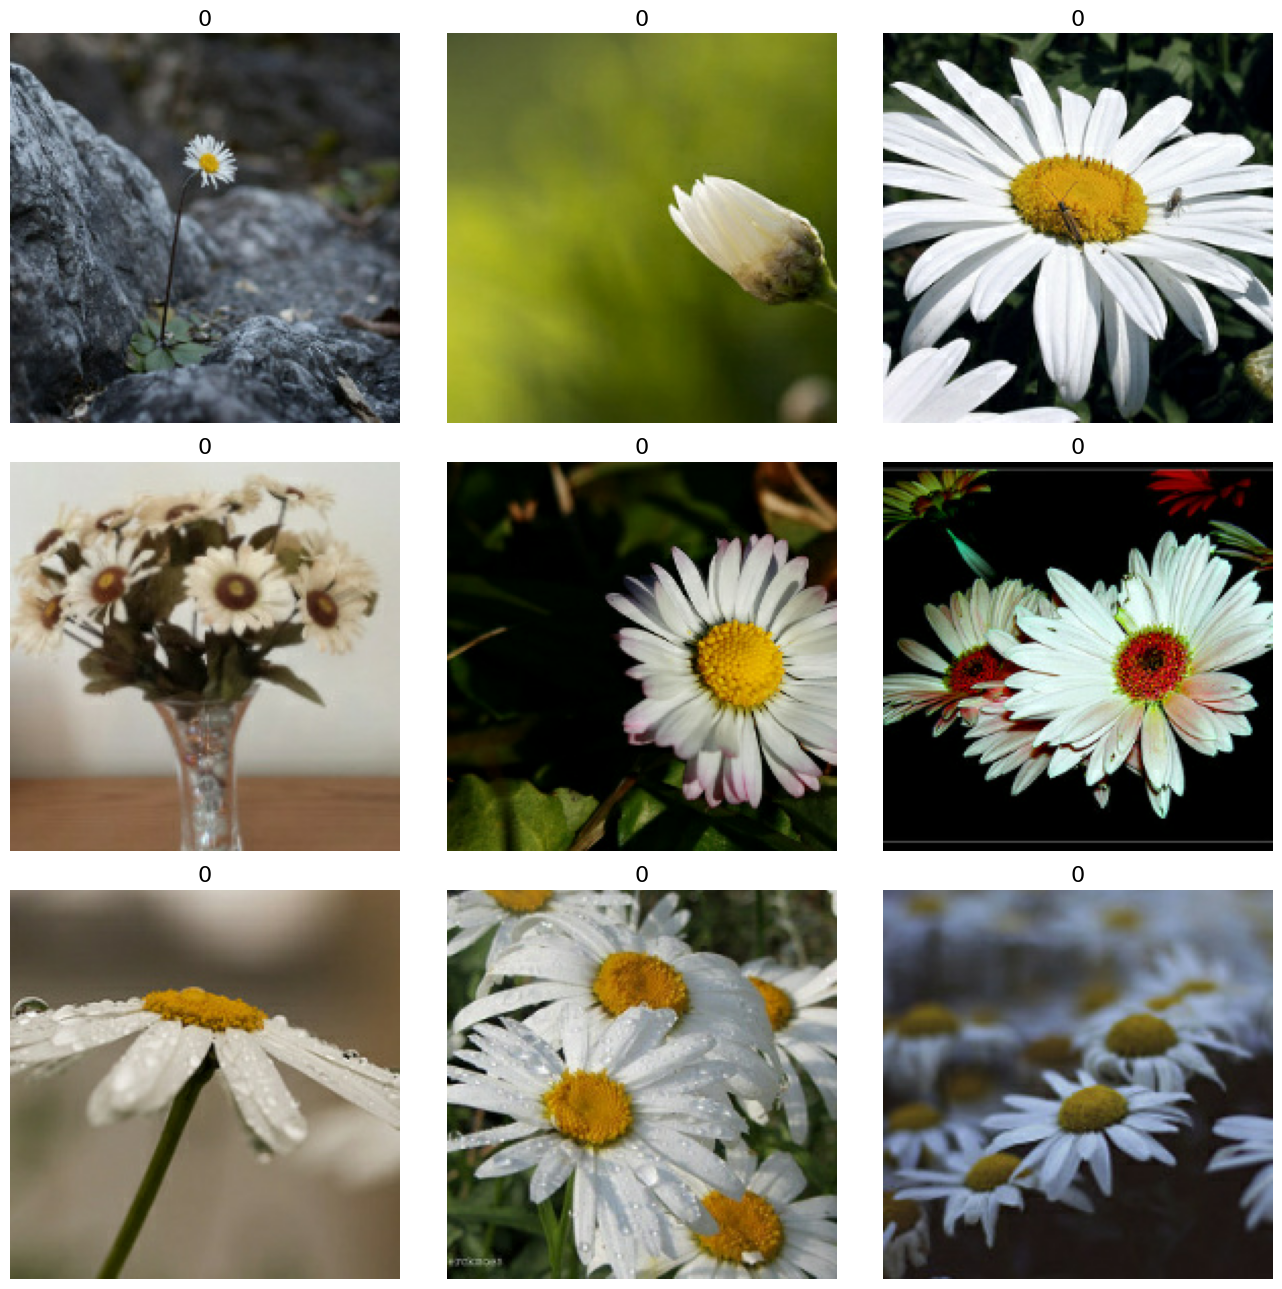

In [ ]:
### CODING TASK 1b.i ###

#using the earlier predefined functions
#running the load again here
#but updating the gcs_out path as the rdd data is stored in a sub directory "flowers" - see examples
#example with tensors: gs://big-data-coursework-420912-storage/tfrecords-jpeg-192x192-2/flowers00-230.tfrec
#example with rdd: gs://big-data-coursework-420912-storage/tfrecords-jpeg-192x192-2/flowers/part-00.tfrec

#GCS_OUTPUT = "gs://big-data-coursework-420912-storage/tfrecords-jpeg-192x192-2/" #tensor
GCS_OUTPUT = "gs://big-data-coursework-420912-storage/tfrecords-jpeg-192x192-2/flowers/" #rdd

filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")
datasetTfrec = load_dataset(filenames)

#displaying the images
display_9_images_from_dataset(datasetTfrec)

ii) Write your code above into a file using the *cell magic* `%%writefile spark_write_tfrec.py` at the beginning of the file. Then, run the file  locally in Spark.



In [ ]:
### CODING TASK 1b.ii ###

%%writefile spark_write_tfrec.py

import os, sys, math
import numpy as np
import time
import datetime
import string
import random
import tensorflow as tf
import pickle
import pyspark
from pyspark.sql import SQLContext

PROJECT = 'big-data-coursework-420912'
BUCKET = 'gs://{}-storage'.format(PROJECT)
GCS_PATTERN = 'gs://flowers-public/*/*.jpg'
GCS_OUTPUT = BUCKET + '/tfrecords-jpeg-192x192-2/flowers'
PARTITIONS = 16

def decode_jpeg_and_label(filepath):
    bits = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(bits)
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')
    label2 = label.values[-2]
    return image, label2

def resize_and_crop_image(image_data):
    image, label = image_data
    w = tf.shape(image)[0]
    h = tf.shape(image)[1]
    tw = TARGET_SIZE[1]
    th = TARGET_SIZE[0]
    resize_crit = (w * th) / (h * tw)
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [w*tw/w, h*tw/w]),
                    lambda: tf.image.resize(image, [w*th/h, h*th/h])
                    )
    nw = tf.shape(image)[0]
    nh = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
    return (image, label)

def recompress_image(image_data):
    image, label = image_data
    image = tf.cast(image, tf.uint8)
    image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
    return (image, label)

sc = pyspark.SparkContext.getOrCreate()

filenames_spark = tf.io.gfile.glob(GCS_PATTERN)
rdd_filenames_spark = sc.parallelize(filenames_spark)

rdd_decode_jpeg_and_label = rdd_filenames_spark.map(decode_jpeg_and_label)
rdd_resize_and_crop_image = rdd_decode_jpeg_and_label.map(resize_and_crop_image)
rdd_recompress_image = rdd_resize_and_crop_image.map(recompress_image)

rdd_filenames_sample_spark = rdd_filenames_spark.sample(False, 0.02)

def _bytestring_feature(list_of_bytestrings):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=list_of_bytestrings))

def _int_feature(list_of_ints):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=list_of_ints))

def to_tfrecord(tfrec_filewriter, img_bytes, label):
    class_num = np.argmax(np.array(CLASSES)==label)
    one_hot_class = np.eye(len(CLASSES))[class_num]
    feature = {
        "image": _bytestring_feature([img_bytes]),
        "class": _int_feature([class_num])
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

def write_tfrecords_updated(partition_index, iteration):
    tt0 = time.time()

    filename = GCS_OUTPUT + "/partition-{:02d}.tfrec".format(partition_index)
    with tf.io.TFRecordWriter(filename) as out_file:
        count = 0
        for image, label in iteration:
            example = to_tfrecord(out_file, image.numpy(), label.numpy())
            out_file.write(example.SerializeToString())
            count += 1

    tt1 = time.time() - tt0
    message = f"Wrote file {filename} containing {count} records in {tt1:.2f} seconds"

    return [(filename, message)]

rdd_partitioning = rdd_recompress_image.repartition(PARTITIONS)
rdd_partitioned_filenames = rdd_partitioning.mapPartitionsWithIndex(write_tfrecords_updated)

Writing spark_write_tfrec.py


In [ ]:
### CODING TASK 1b.ii ###

#running the file locally
#using %run as shown in question 2

%run spark_write_tfrec.py

<Figure size 640x480 with 0 Axes>

### 1c) Set up a cluster and run the script. (6%)

Following the example from the labs, set up a cluster to run PySpark jobs in the cloud. You need to set up so that TensorFlow is installed on all nodes in the cluster.  


#### i) Single machine cluster
Set up a cluster with a single machine using the maximal SSD size (100) and 8 vCPUs.

Enable **package installation** by passing a flag `--initialization-actions` with argument `gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh` (this is a public script that will read metadata to determine which packages to install).
Then, the **packages are specified** by providing a `--metadata` flag with the argument `PIP_PACKAGES=tensorflow==2.4.0`.

Note: consider using `PIP_PACKAGES="tensorflow numpy"` or `PIP_PACKAGES=tensorflow` in case an older version of tensorflow is causing issues.

When the cluster is running, run your script to check that it works and keep the output cell output. (3%)


In [ ]:
### CODING TASK 1c.i ###

#adapting from lab 5 - below comments are the line by line
#creating cluster with dataproc
#storage bucket to use
#image version for nodes and using 1 machine
#master node using 8 cpus
#ssd with 100gb
#path where script is stored
#metadata for installation

!gcloud dataproc clusters create $CLUSTER \
    --bucket $PROJECT-storage \
    --image-version 1.4-ubuntu18 --single-node \
    --master-machine-type n1-standard-8 \
    --master-boot-disk-type pd-ssd --master-boot-disk-size 100\
    --initialization-actions gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh \
    --metadata PIP_PACKAGES="tensorflow numpy" \
    --zone us-central1-c

Waiting on operation [projects/big-data-coursework-420912/regions/us-central1/operations/2301b671-d091-3645-8ad3-3819f7970186].

Created [https://dataproc.googleapis.com/v1/projects/big-data-coursework-420912/regions/us-central1/clusters/big-data-coursework-420912-cluster] Cluster placed in zone [us-central1-c].


Run the script in the cloud and test the output.

In [ ]:
### CODING TASK 1c.i ###

!gcloud dataproc jobs submit pyspark --cluster $CLUSTER \spark_write_tfrec.py

Job [6cc84413dc2241759838b62da2f39915] submitted.
Waiting for job output...
2024-04-22 12:53:18.043008: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-22 12:53:18.210305: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2024-04-22 12:53:18.210347: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-04-22 12:53:19.014352: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dy

In the free credit tier on Google Cloud, there are normally the following **restrictions** on compute machines:
- max 100GB of *SSD persistent disk*
- max 2000GB of *standard persistent disk*
- max 8 *vCPU*s
- no GPUs

See [here](https://cloud.google.com/free/docs/gcp-free-tier#free-trial) for details
The **disks are virtual** disks, where **I/O speed is limited in proportion to the size**, so we should allocate them evenly.
This has mainly an effect on the **time the cluster needs to start**, as we are reading the data mainly from the bucket and we are not writing much to disk at all.  


#### ii) Maximal cluster
Use the **largest possible cluster** within these constraints, i.e. **1 master and 7 worker nodes**.
Each of them with 1 (virtual) CPU.
The master should get the full *SSD* capacity and the 7 worker nodes should get equal shares of the *standard* disk capacity to maximise throughput.

Once the cluster is running, test your script. (3%)

In [ ]:
### CODING TASK 1c.ii ###

#documentation: https://cloud.google.com/compute/docs/disks#:~:text=Local%20SSD%20disks%20have%20higher,on%20the%20number%20of%20vCPUs.

!gcloud dataproc clusters create $CLUSTER \
    --bucket $PROJECT-storage \
    --image-version 1.5-ubuntu18 \
    --master-machine-type n1-standard-1 \
    --master-boot-disk-type pd-ssd --master-boot-disk-size 100 \
    --num-workers 7 --worker-machine-type n1-standard-1 --worker-boot-disk-type pd-standard --worker-boot-disk-size 100 \
    --initialization-actions gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh \
    --metadata PIP_PACKAGES="tensorflow numpy"

ERROR: (gcloud.dataproc.clusters.create) INVALID_ARGUMENT: Insufficient 'IN_USE_ADDRESSES' quota. Requested 8.0, available 4.0. Your resource request exceeds your available quota. See https://cloud.google.com/compute/resource-usage. Use https://cloud.google.com/docs/quotas/view-manage#requesting_higher_quota to request additional quota.


Can not use 8 addresses only have 4

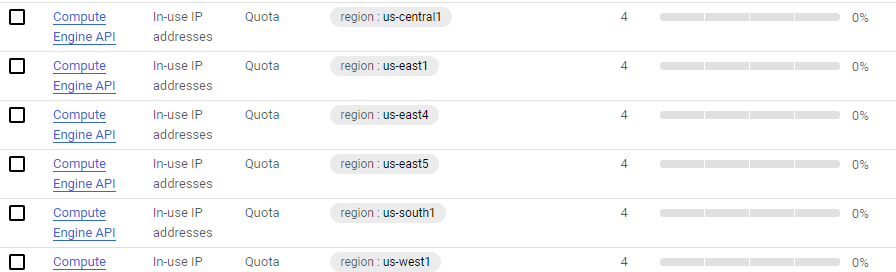

In [ ]:
### CODING TASK 1c.ii ###

#documentation: https://cloud.google.com/compute/docs/disks#:~:text=Local%20SSD%20disks%20have%20higher,on%20the%20number%20of%20vCPUs.

#first was trying different regions and cluster names because i was getting errors
#now will just create cluster > run script > take screen shots > delete cluster

#creating a new cluster name to avoid deleting
#CLUSTER = '{}-cluster'.format(PROJECT)

#trying a new region as i was constantly getting the error "the zone does not have enough resources..."
#REGION = 'us-central1'

#i have been getting too many zone or quota errors and this question has taken days to solve not hours which is unfair
#gcp takes way too long to update quoat limits when you delete a cluster
#you calso can not make all the clusters in this question simultaneously because of the limits so you have to delete and then just keep waiting

!gcloud dataproc clusters create $CLUSTER \
    --bucket $PROJECT-storage \
    --image-version 1.4-ubuntu18 \
    --master-machine-type n1-standard-1 \
    --master-boot-disk-type pd-ssd --master-boot-disk-size 100 \
    --num-workers 3 --worker-machine-type n1-standard-1 --worker-boot-disk-type pd-standard --worker-boot-disk-size 100 \
    --initialization-actions gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh \
    --metadata PIP_PACKAGES="tensorflow numpy" \
    --zone us-central1-c

Waiting on operation [projects/big-data-coursework-420912/regions/us-central1/operations/18b4e441-4972-3745-927c-3aeef9117f74].

Created [https://dataproc.googleapis.com/v1/projects/big-data-coursework-420912/regions/us-central1/clusters/big-data-coursework-420912-cluster] Cluster placed in zone [us-central1-c].


In [ ]:
### CODING TASK 1c.ii ###

!gcloud dataproc jobs submit pyspark --cluster $CLUSTER \spark_write_tfrec.py

Job [6eba068297f4470980114434f7dd45f2] submitted.
Waiting for job output...
2024-04-23 12:55:06.462559: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2024-04-23 12:55:06.462739: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
24/04/23 12:55:10 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
24/04/23 12:55:10 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
24/04/23 12:55:10 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
24/04/23 12:55:10 INFO org.spark_project.jetty.util.log: Logging initialized @8717ms to org.spark_project.jetty.util.log.Slf4jLog
24/04/23 12:55:10 INFO org.spark_project.jetty.server.Server: jetty-9.4.z-SNAPSHOT; built: unknown; git: unknown; 

### 1d)	Optimisation, experiments, and discussion (17%)

i) Improve parallelisation

If you implemented a straightfoward version, you will
**probably** observe that **all the computation** is done on only **two nodes**.
This can be adressed by using the **second parameter** in the initial call to **parallelize**.
Make the **suitable change** in the code you have written above and mark it up in comments as `### TASK 1d ###`.

Demonstrate the difference in cluster utilisation before and after the change based on different parameter values with **screenshots from Google Cloud** and measure the **difference in the processing time**. (6%)

ii) Experiment with cluster configurations.

In addition to the experiments above (using 8 VMs),test your program with 4 machines with double the resources each (2 vCPUs, memory, disk) and 1 machine with eightfold resources.
Discuss the results in terms of disk I/O and network bandwidth allocation in the cloud. (7%)

iii) Explain the difference between this use of Spark and most standard applications like e.g. in our labs in terms of where the data is stored. What kind of parallelisation approach is used here? (4%)

Write the code below and your answers in the report.


In [ ]:
### CODING TASK 1d.i ###

%%writefile spark_write_tfrec2.py

import os, sys, math
import numpy as np
import time
import datetime
import string
import random
import tensorflow as tf
import pickle
import pyspark
from pyspark.sql import SQLContext

PROJECT = 'big-data-coursework-420912'
BUCKET = 'gs://{}-storage'.format(PROJECT)
GCS_PATTERN = 'gs://flowers-public/*/*.jpg'
GCS_OUTPUT = BUCKET + '/tfrecords-jpeg-192x192-2/flowers'
PARTITIONS = 16

def decode_jpeg_and_label(filepath):
    bits = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(bits)
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')
    label2 = label.values[-2]
    return image, label2

def resize_and_crop_image(image_data):
    image, label = image_data
    w = tf.shape(image)[0]
    h = tf.shape(image)[1]
    tw = TARGET_SIZE[1]
    th = TARGET_SIZE[0]
    resize_crit = (w * th) / (h * tw)
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [w*tw/w, h*tw/w]),
                    lambda: tf.image.resize(image, [w*th/h, h*th/h])
                    )
    nw = tf.shape(image)[0]
    nh = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
    return (image, label)

def recompress_image(image_data):
    image, label = image_data
    image = tf.cast(image, tf.uint8)
    image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
    return (image, label)

sc = pyspark.SparkContext.getOrCreate()

filenames_spark = tf.io.gfile.glob(GCS_PATTERN)

### TASK 1d ###
#using the same number of partitions we defined earlier in the notebook
rdd_filenames_spark = sc.parallelize(filenames_spark, 16)

rdd_decode_jpeg_and_label = rdd_filenames_spark.map(decode_jpeg_and_label)
rdd_resize_and_crop_image = rdd_decode_jpeg_and_label.map(resize_and_crop_image)
rdd_recompress_image = rdd_resize_and_crop_image.map(recompress_image)

rdd_filenames_sample_spark = rdd_filenames_spark.sample(False, 0.02)

def _bytestring_feature(list_of_bytestrings):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=list_of_bytestrings))

def _int_feature(list_of_ints):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=list_of_ints))

def to_tfrecord(tfrec_filewriter, img_bytes, label):
    class_num = np.argmax(np.array(CLASSES)==label)
    one_hot_class = np.eye(len(CLASSES))[class_num]
    feature = {
        "image": _bytestring_feature([img_bytes]),
        "class": _int_feature([class_num])
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

def write_tfrecords_updated(partition_index, iteration):
    tt0 = time.time()

    filename = GCS_OUTPUT + "/partition-{:02d}.tfrec".format(partition_index)
    with tf.io.TFRecordWriter(filename) as out_file:
        count = 0
        for image, label in iteration:
            example = to_tfrecord(out_file, image.numpy(), label.numpy())
            out_file.write(example.SerializeToString())
            count += 1

    tt1 = time.time() - tt0
    message = f"Wrote file {filename} containing {count} records in {tt1:.2f} seconds"

    return [(filename, message)]

rdd_partitioning = rdd_recompress_image.repartition(PARTITIONS)
rdd_partitioned_filenames = rdd_partitioning.mapPartitionsWithIndex(write_tfrecords_updated)

Writing spark_write_tfrec2.py


In [ ]:
### CODING TASK 1d.i ###

#using maximal cluster as part 1c.ii
!gcloud dataproc jobs submit pyspark --cluster $CLUSTER \spark_write_tfrec2.py

Job [6af83bb8e79f4cc288bb7badd6292d3a] submitted.
Waiting for job output...
2024-04-23 14:12:47.509574: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2024-04-23 14:12:47.509788: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
24/04/23 14:12:50 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
24/04/23 14:12:50 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
24/04/23 14:12:50 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
24/04/23 14:12:50 INFO org.spark_project.jetty.util.log: Logging initialized @6592ms to org.spark_project.jetty.util.log.Slf4jLog
24/04/23 14:12:51 INFO org.spark_project.jetty.server.Server: jetty-9.4.z-SNAPSHOT; built: unknown; git: unknown; 

In [ ]:
  ### CODING TASK 1d.i ###

#using single machine cluster as part 1c.i
!gcloud dataproc jobs submit pyspark --cluster $CLUSTER \spark_write_tfrec2.py

Job [cefe353003864a338cde430a2dceeb5d] submitted.
Waiting for job output...
2024-04-23 15:09:14.711457: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2024-04-23 15:09:14.711505: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
24/04/23 15:09:17 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
24/04/23 15:09:17 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
24/04/23 15:09:17 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
24/04/23 15:09:17 INFO org.spark_project.jetty.util.log: Logging initialized @5146ms to org.spark_project.jetty.util.log.Slf4jLog
24/04/23 15:09:17 INFO org.spark_project.jetty.server.Server: jetty-9.4.z-SNAPSHOT; built: unknown; git: unknown; 

In [ ]:
### CODING TASK 1d.ii ###
#1 machine with eightfold resources

#for this we will just use a master node with n1 standard 8 which is 1 machine and 8 cpus
#this standard also has about 30 gigs of ram which would be about 8 times as much as what would be avilable in n1-1
#my ssd limit is 100 so i will give this cluster a standard disk size of 800 as my standard limit is 2000
#documentation: https://cloud.google.com/compute/docs/general-purpose-machines#n1_machine_types

!gcloud dataproc clusters create $CLUSTER \
    --bucket $PROJECT-storage \
    --image-version 1.4-ubuntu18 --single-node \
    --master-machine-type n1-standard-8 \
    --master-boot-disk-type pd-standard --master-boot-disk-size 800\
    --initialization-actions gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh \
    --metadata PIP_PACKAGES="tensorflow numpy" \
    --zone us-central1-c

Waiting on operation [projects/big-data-coursework-420912/regions/us-central1/operations/51968029-0b3f-33ec-abfc-65a31e3af0d6].

Created [https://dataproc.googleapis.com/v1/projects/big-data-coursework-420912/regions/us-central1/clusters/big-data-coursework-420912-cluster] Cluster placed in zone [us-central1-c].


In [ ]:
### CODING TASK 1d.ii ###
#1 machine with eightfold resources

!gcloud dataproc jobs submit pyspark --cluster $CLUSTER \spark_write_tfrec2.py

Job [2f4d7828c391431b952bd749c1f96240] submitted.
Waiting for job output...
2024-04-23 16:28:56.049648: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2024-04-23 16:28:56.049690: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
24/04/23 16:28:58 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
24/04/23 16:28:58 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
24/04/23 16:28:58 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
24/04/23 16:28:58 INFO org.spark_project.jetty.util.log: Logging initialized @4608ms to org.spark_project.jetty.util.log.Slf4jLog
24/04/23 16:28:58 INFO org.spark_project.jetty.server.Server: jetty-9.4.z-SNAPSHOT; built: unknown; git: unknown; 

In [ ]:
### CODING TASK 1d.ii ###
#4 machines with double the resources each (2 vCPUs, memory, disk)

#for this we will just use 1 master node with n1 standard 2 which is 1 machine and 2 cpus
#we will use 3 workers with n1-2
#this standard also has about double the ram available
#my ssd limit is 100 so i will give this cluster a standard disk with 200gb each
#documentation: https://cloud.google.com/compute/docs/general-purpose-machines#n1_machine_types

!gcloud dataproc clusters create $CLUSTER \
    --bucket $PROJECT-storage \
    --image-version 1.4-ubuntu18 \
    --master-machine-type n1-standard-2 \
    --master-boot-disk-type pd-standard --master-boot-disk-size 200 \
    --num-workers 3 --worker-machine-type n1-standard-2 --worker-boot-disk-type pd-standard --worker-boot-disk-size 200 \
    --initialization-actions gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh \
    --metadata PIP_PACKAGES="tensorflow numpy" \
    --zone us-central1-c

Waiting on operation [projects/big-data-coursework-420912/regions/us-central1/operations/d3d99637-3942-34e6-8e6e-763f48fec1b4].

Created [https://dataproc.googleapis.com/v1/projects/big-data-coursework-420912/regions/us-central1/clusters/big-data-coursework-420912-cluster] Cluster placed in zone [us-central1-c].


In [ ]:
### CODING TASK 1d.ii ###
#4 machines with double the resources each (2 vCPUs, memory, disk)

!gcloud dataproc jobs submit pyspark --cluster $CLUSTER \spark_write_tfrec2.py

Job [8accbe90596e4921877d953601c374f3] submitted.
Waiting for job output...
2024-04-23 16:45:49.921268: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2024-04-23 16:45:49.921311: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
24/04/23 16:45:52 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
24/04/23 16:45:52 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
24/04/23 16:45:52 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
24/04/23 16:45:53 INFO org.spark_project.jetty.util.log: Logging initialized @5954ms to org.spark_project.jetty.util.log.Slf4jLog
24/04/23 16:45:53 INFO org.spark_project.jetty.server.Server: jetty-9.4.z-SNAPSHOT; built: unknown; git: unknown; 

In [1]:
#BELOW DISCUSSION QUESTIONS HAVE BEEN ANSWERED IN THE REPORT

#Demonstrate the difference in cluster utilisation before and after the change based on different parameter
#values with screenshots from Google Cloud and measure the difference in the processing time. (6%)


#In addition to the experiments above (using 8 VMs),test your program with 4 machines with double the resources each
#(2 vCPUs, memory, disk) and 1 machine with eightfold resources.
#Discuss the results in terms of disk I/O and network bandwidth allocation in the cloud. (7%)

#Explain the difference between this use of Spark and most standard applications like
#e.g. in our labs in terms of where the data is stored. What kind of parallelisation approach is used here? (4%)

# Section 2: Speed tests

We have seen that **reading from the pre-processed TFRecord files** is **faster** than reading individual image files and decoding on the fly.
This task is about **measuring this effect** and **parallelizing the tests with PySpark**.

## 2.1 Speed test implementation

Here is **code for time measurement** to determine the **throughput in images per second**.
It doesn't render the images but extracts and prints some basic information in order to make sure the image data are read.
We write the information to the null device for longer measurements `null_file=open("/dev/null", mode='w')`.
That way it will not clutter our cell output.

We use batches ( `dset2 = dset1.batch(batch_size)` ) and select a number of batches with (`dset3 = dset2.take(batch_number)`).
Then we  use the `time.time()` to take the **time measurement** and take it multiple times, reading from the same dataset to see if reading speed changes with mutiple readings.

We then **vary** the size of the batch (`batch_size`) and the number of batches (`batch_number`) and **store the results for different values**.
Store also the **results for each repetition** over the same dataset (repeat 2 or 3 times).

The speed test should be combined in a **function** `time_configs()` that takes a configuration, i.e. a dataset and arrays of `batch_sizes`, `batch_numbers`, and  `repetitions` (an array of integers starting from 1), as **arguments** and runs the time measurement for each combination of batch_size and batch_number for the requested number of repetitions.

In [ ]:
# Here are some useful values for testing your code, use higher values later for actually testing throughput
batch_sizes = [2,4]
batch_numbers = [3,6]
repetitions = [1]

def time_configs(dataset, batch_sizes, batch_numbers, repetitions):
    dims = [len(batch_sizes),len(batch_numbers),len(repetitions)]
    print(dims)
    results = np.zeros(dims)
    params = np.zeros(dims + [3])
    print( results.shape )
    with open("/dev/null",mode='w') as null_file: # for printing the output without showing it
        tt = time.time() # for overall time taking
        for bsi,bs in enumerate(batch_sizes):
            for dsi, ds in enumerate(batch_numbers):
                batched_dataset = dataset.batch(bs)
                timing_set = batched_dataset.take(ds)
                for ri,rep in enumerate(repetitions):
                    print("bs: {}, ds: {}, rep: {}".format(bs,ds,rep))
                    t0 = time.time()
                    for image, label in timing_set:
                        #print("Image batch shape {}".format(image.numpy().shape),
                        print("Image batch shape {}, {})".format(image.numpy().shape,
                            [str(lbl) for lbl in label.numpy()]), null_file)
                    td = time.time() - t0 # duration for reading images
                    results[bsi,dsi,ri] = ( bs * ds) / td
                    params[bsi,dsi,ri] = [ bs, ds, rep ]
    print("total time: "+str(time.time()-tt))
    return results, params

**Let's try this function** with a **small number** of configurations of batch_sizes batch_numbers and repetions, so that we get a set of parameter combinations and corresponding reading speeds.
Try reading from the image files (dataset4) and the TFRecord files (datasetTfrec).

In [ ]:
[res,par] = time_configs(dataset4, batch_sizes, batch_numbers, repetitions)
print(res)
print(par)

print("=============")

[res,par] = time_configs(datasetTfrec, batch_sizes, batch_numbers, repetitions)
print(res)
print(par)

[2, 2, 1]
(2, 2, 1)
bs: 2, ds: 3, rep: 1
Image batch shape (2,), ["b'roses'", "b'sunflowers'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
Image batch shape (2,), ["b'roses'", "b'sunflowers'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
Image batch shape (2,), ["b'daisy'", "b'daisy'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
bs: 2, ds: 6, rep: 1
Image batch shape (2,), ["b'daisy'", "b'dandelion'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
Image batch shape (2,), ["b'dandelion'", "b'tulips'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
Image batch shape (2,), ["b'dandelion'", "b'sunflowers'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
Image batch shape (2,), ["b'tulips'", "b'tulips'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
Image batch shape (2,), ["b'roses'", "b'tulips'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
Ima

## Task 2: Parallelising the speed test with Spark in the cloud. (36%)

As an exercise in **Spark programming and optimisation** as well as **performance analysis**, we will now implement the **speed test** with multiple parameters in parallel with Spark.
Runing multiple tests in parallel would **not be a useful approach on a single machine, but it can be in the cloud** (you will be asked to reason about this later).


### 2a) Create the script (14%)
Your task is now to **port the speed test above to Spark** for running it in the cloud in Dataproc.
**Adapt the speed testing** as a Spark program that performs the same actions as above, but **with Spark RDDs in a distributed way**.
The distribution should be such that **each parameter combination (except repetition)** is processed in a separate Spark task.

More specifically:
*   i) combine the previous cells to have the code to create a dataset and create a list of parameter combinations in an RDD (2%)
*   ii) get a Spark context and  create the dataset and run timing test for each combination in parallel (2%)
*   iii) transform the resulting RDD to the structure \( parameter_combination, images_per_second \) and save these values in an array (2%)
*   iv) create an RDD with all results for each parameter as (parameter_value,images_per_second) and collect the result for each parameter  (2%)
*   v) create an RDD with the average reading speeds for each parameter value and collect the results. Keep associativity in mind when implementing the average. (3%)
*   vi) write the results to a pickle file in your bucket (2%)
*   vii) Write your code it into a file using the *cell magic* `%%writefile spark_job.py` (1%)


**Important:** The task here is not to parallelize the pre-processing, but to run multiple speed tests in parallel using Spark.


In [ ]:
### CODING TASK 2a.i and 2a.ii ###

#i have renamed the variables as below in the proceeding code
#NOTE TFRecord = unprocessed
#NOTE dataset4/image files = processed

sc = pyspark.SparkContext.getOrCreate()


#----- parameter combinations (start) -----#

#creating a list of parameters and turning them into an rdd to be used
#initially i was trying to use zip as i know that it makes combinations from inputs
#this was giving me an incomplete result and i was lead towards product which worked a lot better
#the same could have also been accomplished with a for loop honestly but that was not my first instinct - i went with zip first

import itertools

#starting with the same values as before and adding a few
#these were intial values but .colect() was taking too long so thought to reduce the load
#same with iterations later in the code
#batch_sizes = [2, 4, 6, 8, 10, 12]
#batch_numbers = [3, 6, 9, 12, 15, 18]

batch_sizes = [2, 4, 6]
batch_numbers = [3, 6, 9]

#useing the .product to get the combinations and then creating an rdd
#since every combination except reptition should be preformed as a spark task (likley because of the computational cloud cost)
#we will make a param combination using just batch size and numbers and we will loop inside the respective functions for repititions
parameter_combinations = list(itertools.product(batch_sizes, batch_numbers))
#rdd_parameter_combinations = sc.parallelize(parameter_combinations)

#----- parameter combinations (end) -----#


#----- for processed data (start) -----#

#we will re run the tensor processing to get the processed data
#this is essentially dataset4

def decode_jpeg_and_label(filepath):
    bits = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(bits)
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')
    label2 = label.values[-2]
    return image, label2

def resize_and_crop_image(image, label):
    w = tf.shape(image)[0]
    h = tf.shape(image)[1]
    tw = TARGET_SIZE[1]
    th = TARGET_SIZE[0]
    resize_crit = (w * th) / (h * tw)
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                    lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                    )
    nw = tf.shape(image)[0]
    nh = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
    return image, label

def recompress_image(image, label):
    image = tf.cast(image, tf.uint8)
    image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
    return image, label

#creating a wrapper function to decode data directly in the time config function and easier to read
def load_decoded_data():
  dsetFiles = tf.data.Dataset.list_files(GCS_PATTERN)
  dsetDecoded = dsetFiles.map(decode_jpeg_and_label)
  processed_data = dsetDecoded.map(resize_and_crop_image)
  return processed_data


#----- for processed data (end) -----#


#----- for unprocessed data (start) -----#

#lets re run the read_tfrecord and load_dataset code from the previous section to create our dataset
#we will also reset the path to read from the initial tensor data
#this is essentially datasetTfrec

def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])
    class_num = example['class']
    #return np.array(image.numpy()), class_num.numpy()
    return image, class_num

def load_dataset(filenames):
    # read from TFRecords. For optimal performance, read from multiple
    # TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord)
    return dataset

GCS_OUTPUT = "gs://big-data-coursework-420912-storage/tfrecords-jpeg-192x192-2/" #tensor

#----- for unprocessed data (end) -----#


#----- for updating time confguration code to use rdd parameter combination (start) -----#

#setting up 2 functions to process the data and store separately
#could have done in one function by adding the dataset as a parameter as well but that was increasing the complexity

#function for processed data
def time_configs_processed_updated(parameter_combinations):
  batch_sizes, batch_numbers = parameter_combinations
  repetitions = [1, 2, 3]
  data = load_decoded_data()
  processed_data_results = []

  for repetitions in repetitions:
        for numbers in range(batch_numbers):
            batched_data = data.batch(batch_sizes)
            timing_set = batched_data.take(batch_numbers)
            t0 = time.time()
            for images in timing_set:
              pass
            time_taken = time.time() - t0
            throughput = (batch_sizes * batch_numbers) / time_taken
            processed_data_results.append((batch_sizes, batch_numbers, repetitions, throughput, time_taken))

  return processed_data_results

#function for unprocessed data
def time_configs_unprocessed_updated(parameter_combinations):
  batch_sizes, batch_numbers = parameter_combinations
  repetitions = [1, 2, 3]
  filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")
  data = load_dataset(filenames)
  unprocessed_data_results = []

  for repetitions in repetitions:
        for numbers in range(batch_numbers):
            batched_data = data.batch(batch_sizes)
            timing_set = batched_data.take(batch_numbers)
            t0 = time.time()
            for images in timing_set:
              pass
            time_taken = time.time() - t0
            throughput = (batch_sizes * batch_numbers) / time_taken
            unprocessed_data_results.append((batch_sizes, batch_numbers, repetitions, throughput, time_taken))

  return unprocessed_data_results

#----- for updating time confguration code to use rdd parameter combination (end) -----#

In [ ]:
### CODING TASK 2a.i and 2a.ii continued ###

#we will parralelize separate combinations and since we are using lists of lists we will need to flatten
#documentation: https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.flatMap.html

rdd_processed_data_parameters = sc.parallelize(parameter_combinations)
rdd_unprocessed_data_parameters = sc.parallelize(parameter_combinations)

rdd_processed_data = rdd_processed_data_parameters.flatMap(time_configs_processed_updated)
rdd_unprocessed_data = rdd_unprocessed_data_parameters.flatMap(time_configs_unprocessed_updated)

In [ ]:
unprocessed_data_array = rdd_unprocessed_data.collect()
processed_data_array = rdd_processed_data.collect()

In [ ]:
### CODING TASK 2a.iii ###

#creating a function to get the throughtput and combination and then mapping them to an rdd

def get_combination_and_throughput(mapped_rdd):
    parameter_combination = (mapped_rdd[0], mapped_rdd[1], mapped_rdd[2])
    images_per_second = mapped_rdd[3]
    return (parameter_combination, images_per_second)

rdd_processed_performance = rdd_processed_data.map(get_combination_and_throughput)
rdd_unprocessed_performance = rdd_unprocessed_data.map(get_combination_and_throughput)

In [ ]:
#rdd_processed_performance.take(6)

[((2, 3, 1), 8.209206732470827),
 ((2, 3, 1), 7.256072887626386),
 ((2, 3, 1), 7.560841979520749),
 ((2, 3, 2), 6.551220064585912),
 ((2, 3, 2), 7.403422260727845),
 ((2, 3, 2), 10.080841980114572)]

In [ ]:
### CODING TASK 2a.iii ###

#this was taking too long before chaning the parameters
processed_performance_array = rdd_processed_performance.collect()
unprocessed_performance_array = rdd_unprocessed_performance.collect()

In [ ]:
### CODING TASK 2a.iv ###

#we will use the code from 3 and make multiple functions for each parameter and follow the same process

def get_batch_size_and_throughput(mapped_rdd):
    batch_size = (mapped_rdd[0])
    images_per_second = mapped_rdd[3]
    return (batch_size, images_per_second)

def get_batch_number_and_throughput(mapped_rdd):
    batch_number = (mapped_rdd[1])
    images_per_second = mapped_rdd[3]
    return (batch_number, images_per_second)

def get_repetition_and_throughput(mapped_rdd):
    repetition = (mapped_rdd[2])
    images_per_second = mapped_rdd[3]
    return (repetition, images_per_second)

#adding new function after getting to the regressions and finding out that we need the product of the two as well
def get_batch_size_and_batch_number_product_and_throughput(mapped_rdd):
    batch_size_batch_number_product = mapped_rdd[0] * mapped_rdd[1]
    images_per_second = mapped_rdd[3]
    return (batch_size_batch_number_product, images_per_second)

rdd_processed_performance_batch_size = rdd_processed_data.map(get_batch_size_and_throughput)
rdd_processed_performance_batch_number = rdd_processed_data.map(get_batch_number_and_throughput)
rdd_processed_performance_repetitions = rdd_processed_data.map(get_repetition_and_throughput)
rdd_processed_performance_batch_size_batch_number_product = rdd_processed_data.map(get_batch_size_and_batch_number_product_and_throughput)

rdd_unprocessed_performance_batch_size = rdd_unprocessed_data.map(get_batch_size_and_throughput)
rdd_unprocessed_performance_batch_number = rdd_unprocessed_data.map(get_batch_number_and_throughput)
rdd_unprocessed_performance_repetitions = rdd_unprocessed_data.map(get_repetition_and_throughput)
rdd_unprocessed_performance_batch_size_batch_number_product = rdd_unprocessed_data.map(get_batch_size_and_batch_number_product_and_throughput)

In [ ]:
### CODING TASK 2a.iv ###

#this was taking too long before reducing the parameters

rdd_processed_performance_batch_size_array = rdd_processed_performance_batch_size.collect()
rdd_processed_performance_batch_number_array = rdd_processed_performance_batch_number.collect()
rdd_processed_performance_repetitions_array = rdd_processed_performance_repetitions.collect()
rdd_processed_performance_batch_size_batch_number_product_array = rdd_processed_performance_batch_size_batch_number_product.collect()

rdd_unprocessed_performance_batch_size_array = rdd_unprocessed_performance_batch_size.collect()
rdd_unprocessed_performance_batch_number_array = rdd_unprocessed_performance_batch_number.collect()
rdd_unprocessed_performance_repetitions_array = rdd_unprocessed_performance_repetitions.collect()
rdd_unprocessed_performance_batch_size_batch_number_product_array = rdd_unprocessed_performance_batch_size_batch_number_product.collect()

In [ ]:
### CODING TASK 2a.v ###

#documentation: https://proedu.co/spark/apache-spark-rdd-groupby-transformation/
#documentation: https://proedu.co/spark/apache-spark-rdd-groupbykey-transformation/
#documentation: https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.mean.html
#documentation: https://stackoverflow.com/questions/29930110/calculating-the-averages-for-each-key-in-a-pairwise-k-v-rdd-in-spark-with-pyth

#thinking about this like sql where we would do a group by and then an average

#groups for processed data
rdd_processed_grouped_batch_size = rdd_processed_performance_batch_size.groupByKey()
rdd_processed_grouped_batch_number = rdd_processed_performance_batch_number.groupByKey()
rdd_processed_grouped_repetitions = rdd_processed_performance_repetitions.groupByKey()
rdd_processed_grouped_batch_size_batch_number_product = rdd_processed_performance_batch_size_batch_number_product.groupByKey()

#groups for unprocessed data
rdd_unprocessed_grouped_batch_size = rdd_unprocessed_performance_batch_size.groupByKey()
rdd_unprocessed_grouped_batch_number = rdd_unprocessed_performance_batch_number.groupByKey()
rdd_unprocessed_grouped_repetitions = rdd_unprocessed_performance_repetitions.groupByKey()
rdd_unprocessed_grouped_batch_size_batch_number_product = rdd_unprocessed_performance_batch_size_batch_number_product.groupByKey()

#while spark has an rdd.mean that only apparently works on rdds that just have a value, not like our pairs above
#i could split these up further into rdds but thinking about it like sql was easier for me
#could also use the reduce by key which is less computationally expensive but stuck with groupbykey because it was the more straightforward approach

def mean(parameter_rdd):
    return parameter_rdd.mapValues(lambda values: sum(values) / len(values))

#processed averages
mean_processed_throughput_batch_size = mean(rdd_processed_grouped_batch_size)
mean_processed_throughput_batch_number = mean(rdd_processed_grouped_batch_number)
mean_processed_throughput_repetitions = mean(rdd_processed_grouped_repetitions)
mean_processed_throughput_batch_size_batch_number_product = mean(rdd_processed_grouped_batch_size_batch_number_product)

#unprocessed averages
mean_unprocessed_throughput_batch_size = mean(rdd_unprocessed_grouped_batch_size)
mean_unprocessed_throughput_batch_number = mean(rdd_unprocessed_grouped_batch_number)
mean_unprocessed_throughput_repetitions = mean(rdd_unprocessed_grouped_repetitions)
mean_unprocessed_throughput_batch_size_batch_number_product = mean(rdd_unprocessed_grouped_batch_size_batch_number_product)

#associativity makes sure the order does not matter
#we are manually calculating so no order invoked
#documentation: https://stackoverflow.com/questions/930486/what-is-associativity-of-operators-and-why-is-it-important

In [ ]:
### CODING TASK 2a.v ###

#this was taking too long before

#processed averages array
mean_processed_throughput_batch_size_array = mean_processed_throughput_batch_size.collect()
mean_processed_throughput_batch_number_array = mean_processed_throughput_batch_number.collect()
mean_processed_throughput_repetitions_array = mean_processed_throughput_repetitions.collect()
mean_processed_throughput_batch_size_batch_number_product_array = mean_processed_throughput_batch_size_batch_number_product.collect()

#unprocessed averages array
mean_unprocessed_throughput_batch_size_array = mean_unprocessed_throughput_batch_size.collect()
mean_unprocessed_throughput_batch_number_array = mean_unprocessed_throughput_batch_number.collect()
mean_unprocessed_throughput_repetitions_array = mean_unprocessed_throughput_repetitions.collect()
mean_unprocessed_throughput_batch_size_batch_number_product_array = mean_unprocessed_throughput_batch_size_batch_number_product.collect()

In [ ]:
#mean_unprocessed_throughput_repetitions.take(1)

[(4, 378.57974636321495)]

In [ ]:
### CODING TASK 2a.vi ###

#creating pickle files to write
#documentation: https://blog.hubspot.com/website/python-pickle#:~:text=To%20use%20pickle%20in%20Python,stored%20correctly%20for%20later%20access.

filename = "throughput_results.pkl"
with open(filename, mode='wb') as f:
      pickle.dump(processed_performance_array,f)
      pickle.dump(unprocessed_performance_array,f)
      pickle.dump(rdd_processed_performance_batch_size_array,f)
      pickle.dump(rdd_processed_performance_batch_number_array,f)
      pickle.dump(rdd_processed_performance_repetitions_array,f)
      pickle.dump(rdd_processed_performance_batch_size_batch_number_product_array,f)
      pickle.dump(rdd_unprocessed_performance_batch_size_array,f)
      pickle.dump(rdd_unprocessed_performance_batch_number_array,f)
      pickle.dump(rdd_unprocessed_performance_repetitions_array,f)
      pickle.dump(rdd_unprocessed_performance_batch_size_batch_number_product_array,f)
      pickle.dump(mean_processed_throughput_batch_size_array,f)
      pickle.dump(mean_processed_throughput_batch_number_array,f)
      pickle.dump(mean_processed_throughput_repetitions_array,f)
      pickle.dump(mean_processed_throughput_batch_size_batch_number_product_array,f)
      pickle.dump(mean_unprocessed_throughput_batch_size_array,f)
      pickle.dump(mean_unprocessed_throughput_batch_number_array,f)
      pickle.dump(mean_unprocessed_throughput_repetitions_array,f)
      pickle.dump(mean_unprocessed_throughput_batch_size_batch_number_product_array,f)

#documentation: https://docs.python.org/3/library/subprocess.html#module-subprocess
import subprocess
cloud_pickle = subprocess.run(["gsutil", "cp", filename, BUCKET])

In [ ]:
### CODING TASK 2a.vii ###

%%writefile spark_write_throughput.py

import os, sys, math
import numpy as np
import time
import datetime
import string
import random
import tensorflow as tf
import pickle
import pyspark
from pyspark.sql import SQLContext

PROJECT = 'big-data-coursework-420912'
BUCKET = 'gs://{}-storage'.format(PROJECT)
GCS_PATTERN = 'gs://flowers-public/*/*.jpg'
GCS_OUTPUT = BUCKET + '/tfrecords-jpeg-192x192-2/flowers'
PARTITIONS = 16
TARGET_SIZE = [192, 192]

sc = pyspark.SparkContext.getOrCreate()


#----- parameter combinations (start) -----#

#creating a list of parameters and turning them into an rdd to be used
#initially i was trying to use zip as i know that it makes combinations from inputs
#this was giving me an incomplete result and i was lead towards product which worked a lot better
#the same could have also been accomplished with a for loop honestly but that was not my first instinct - i went with zip first

import itertools

#starting with the same values as before and adding a few
#these were intial values but .colect() was taking too long so thought to reduce the load
#same with iterations later in the code
#batch_sizes = [2, 4, 6, 8, 10, 12]
#batch_numbers = [3, 6, 9, 12, 15, 18]

batch_sizes = [2, 4, 6]
batch_numbers = [3, 6, 9]

#useing the .product to get the combinations and then creating an rdd
#since every combination except reptition should be preformed as a spark task (likley because of the computational cloud cost)
#we will make a param combination using just batch size and numbers and we will loop inside the respective functions for repititions
parameter_combinations = list(itertools.product(batch_sizes, batch_numbers))
#rdd_parameter_combinations = sc.parallelize(parameter_combinations)

#----- parameter combinations (end) -----#


#----- for processed data (start) -----#

#we will re run the tensor processing to get the processed data
#this is essentially dataset4

def decode_jpeg_and_label(filepath):
    bits = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(bits)
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')
    label2 = label.values[-2]
    return image, label2

def resize_and_crop_image(image, label):
    w = tf.shape(image)[0]
    h = tf.shape(image)[1]
    tw = TARGET_SIZE[1]
    th = TARGET_SIZE[0]
    resize_crit = (w * th) / (h * tw)
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                    lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                    )
    nw = tf.shape(image)[0]
    nh = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
    return image, label

def recompress_image(image, label):
    image = tf.cast(image, tf.uint8)
    image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
    return image, label

#creating a wrapper function to decode data directly in the time config function and easier to read
def load_decoded_data():
  dsetFiles = tf.data.Dataset.list_files(GCS_PATTERN)
  dsetDecoded = dsetFiles.map(decode_jpeg_and_label)
  processed_data = dsetDecoded.map(resize_and_crop_image)
  return processed_data


#----- for processed data (end) -----#


#----- for unprocessed data (start) -----#

#lets re run the read_tfrecord and load_dataset code from the previous section to create our dataset
#we will also reset the path to read from the initial tensor data
#this is essentially datasetTfrec

def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])
    class_num = example['class']
    #return np.array(image.numpy()), class_num.numpy()
    return image, class_num

def load_dataset(filenames):
    # read from TFRecords. For optimal performance, read from multiple
    # TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord)
    return dataset

GCS_OUTPUT = "gs://big-data-coursework-420912-storage/tfrecords-jpeg-192x192-2/" #tensor

#----- for unprocessed data (end) -----#


#----- for updating time confguration code to use rdd parameter combination (start) -----#

#setting up 2 functions to process the data and store separately
#could have done in one function by adding the dataset as a parameter as well but that was increasing the complexity

#function for processed data
def time_configs_processed_updated(parameter_combinations):
  batch_sizes, batch_numbers = parameter_combinations
  repetitions = [1, 2, 3]
  data = load_decoded_data()
  processed_data_results = []

  for repetitions in repetitions:
        for numbers in range(batch_numbers):
            batched_data = data.batch(batch_sizes)
            timing_set = batched_data.take(batch_numbers)
            t0 = time.time()
            for images in timing_set:
              pass
            time_taken = time.time() - t0
            throughput = (batch_sizes * batch_numbers) / time_taken
            processed_data_results.append((batch_sizes, batch_numbers, repetitions, throughput, time_taken))

  return processed_data_results

#function for unprocessed data
def time_configs_unprocessed_updated(parameter_combinations):
  batch_sizes, batch_numbers = parameter_combinations
  repetitions = [1, 2, 3]
  filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")
  data = load_dataset(filenames)
  unprocessed_data_results = []

  for repetitions in repetitions:
        for numbers in range(batch_numbers):
            batched_data = data.batch(batch_sizes)
            timing_set = batched_data.take(batch_numbers)
            t0 = time.time()
            for images in timing_set:
              pass
            time_taken = time.time() - t0
            throughput = (batch_sizes * batch_numbers) / time_taken
            unprocessed_data_results.append((batch_sizes, batch_numbers, repetitions, throughput, time_taken))

  return unprocessed_data_results

#----- for updating time confguration code to use rdd parameter combination (end) -----#

rdd_processed_data_parameters = sc.parallelize(parameter_combinations)
rdd_unprocessed_data_parameters = sc.parallelize(parameter_combinations)

rdd_processed_data = rdd_processed_data_parameters.flatMap(time_configs_processed_updated)
rdd_unprocessed_data = rdd_unprocessed_data_parameters.flatMap(time_configs_unprocessed_updated)

unprocessed_data_array = rdd_unprocessed_data.collect()
processed_data_array = rdd_processed_data.collect()

def get_combination_and_throughput(mapped_rdd):
    parameter_combination = (mapped_rdd[0], mapped_rdd[1], mapped_rdd[2])
    images_per_second = mapped_rdd[3]
    return (parameter_combination, images_per_second)

rdd_processed_performance = rdd_processed_data.map(get_combination_and_throughput)
rdd_unprocessed_performance = rdd_unprocessed_data.map(get_combination_and_throughput)

processed_performance_array = rdd_processed_performance.collect()
unprocessed_performance_array = rdd_unprocessed_performance.collect()

def get_batch_size_and_throughput(mapped_rdd):
    batch_size = (mapped_rdd[0])
    images_per_second = mapped_rdd[3]
    return (batch_size, images_per_second)

def get_batch_number_and_throughput(mapped_rdd):
    batch_number = (mapped_rdd[1])
    images_per_second = mapped_rdd[3]
    return (batch_number, images_per_second)

def get_repetition_and_throughput(mapped_rdd):
    repetition = (mapped_rdd[2])
    images_per_second = mapped_rdd[3]
    return (repetition, images_per_second)

#adding new function after getting to the regressions and finding out that we need the product of the two as well
def get_batch_size_and_batch_number_product_and_throughput(mapped_rdd):
    batch_size_batch_number_product = mapped_rdd[0] * mapped_rdd[1]
    images_per_second = mapped_rdd[3]
    return (batch_size_batch_number_product, images_per_second)

rdd_processed_performance_batch_size = rdd_processed_data.map(get_batch_size_and_throughput)
rdd_processed_performance_batch_number = rdd_processed_data.map(get_batch_number_and_throughput)
rdd_processed_performance_repetitions = rdd_processed_data.map(get_repetition_and_throughput)
rdd_processed_performance_batch_size_batch_number_product = rdd_processed_data.map(get_batch_size_and_batch_number_product_and_throughput)

rdd_unprocessed_performance_batch_size = rdd_unprocessed_data.map(get_batch_size_and_throughput)
rdd_unprocessed_performance_batch_number = rdd_unprocessed_data.map(get_batch_number_and_throughput)
rdd_unprocessed_performance_repetitions = rdd_unprocessed_data.map(get_repetition_and_throughput)
rdd_unprocessed_performance_batch_size_batch_number_product = rdd_unprocessed_data.map(get_batch_size_and_batch_number_product_and_throughput)

rdd_processed_performance_batch_size_array = rdd_processed_performance_batch_size.collect()
rdd_processed_performance_batch_number_array = rdd_processed_performance_batch_number.collect()
rdd_processed_performance_repetitions_array = rdd_processed_performance_repetitions.collect()
rdd_processed_performance_batch_size_batch_number_product_array = rdd_processed_performance_batch_size_batch_number_product.collect()

rdd_unprocessed_performance_batch_size_array = rdd_unprocessed_performance_batch_size.collect()
rdd_unprocessed_performance_batch_number_array = rdd_unprocessed_performance_batch_number.collect()
rdd_unprocessed_performance_repetitions_array = rdd_unprocessed_performance_repetitions.collect()
rdd_unprocessed_performance_batch_size_batch_number_product_array = rdd_unprocessed_performance_batch_size_batch_number_product.collect()

#groups for processed data
rdd_processed_grouped_batch_size = rdd_processed_performance_batch_size.groupByKey()
rdd_processed_grouped_batch_number = rdd_processed_performance_batch_number.groupByKey()
rdd_processed_grouped_repetitions = rdd_processed_performance_repetitions.groupByKey()
rdd_processed_grouped_batch_size_batch_number_product = rdd_processed_performance_batch_size_batch_number_product.groupByKey()

#groups for unprocessed data
rdd_unprocessed_grouped_batch_size = rdd_unprocessed_performance_batch_size.groupByKey()
rdd_unprocessed_grouped_batch_number = rdd_unprocessed_performance_batch_number.groupByKey()
rdd_unprocessed_grouped_repetitions = rdd_unprocessed_performance_repetitions.groupByKey()
rdd_unprocessed_grouped_batch_size_batch_number_product = rdd_unprocessed_performance_batch_size_batch_number_product.groupByKey()

#while spark has an rdd.mean that only apparently works on rdds that just have a value, not like our pairs above
#i could split these up further into rdds but thinking about it like sql was easier for me
#could also use the reduce by key which is less computationally expensive but stuck with groupbykey because it was the more straightforward approach

def mean(parameter_rdd):
    return parameter_rdd.mapValues(lambda values: sum(values) / len(values))

#processed averages
mean_processed_throughput_batch_size = mean(rdd_processed_grouped_batch_size)
mean_processed_throughput_batch_number = mean(rdd_processed_grouped_batch_number)
mean_processed_throughput_repetitions = mean(rdd_processed_grouped_repetitions)
mean_processed_throughput_batch_size_batch_number_product = mean(rdd_processed_grouped_batch_size_batch_number_product)

#unprocessed averages
mean_unprocessed_throughput_batch_size = mean(rdd_unprocessed_grouped_batch_size)
mean_unprocessed_throughput_batch_number = mean(rdd_unprocessed_grouped_batch_number)
mean_unprocessed_throughput_repetitions = mean(rdd_unprocessed_grouped_repetitions)
mean_unprocessed_throughput_batch_size_batch_number_product = mean(rdd_unprocessed_grouped_batch_size_batch_number_product)

#processed averages array
mean_processed_throughput_batch_size_array = mean_processed_throughput_batch_size.collect()
mean_processed_throughput_batch_number_array = mean_processed_throughput_batch_number.collect()
mean_processed_throughput_repetitions_array = mean_processed_throughput_repetitions.collect()
mean_processed_throughput_batch_size_batch_number_product_array = mean_processed_throughput_batch_size_batch_number_product.collect()

#unprocessed averages array
mean_unprocessed_throughput_batch_size_array = mean_unprocessed_throughput_batch_size.collect()
mean_unprocessed_throughput_batch_number_array = mean_unprocessed_throughput_batch_number.collect()
mean_unprocessed_throughput_repetitions_array = mean_unprocessed_throughput_repetitions.collect()
mean_unprocessed_throughput_batch_size_batch_number_product_array = mean_unprocessed_throughput_batch_size_batch_number_product.collect()

filename = "throughput_results.pkl"
with open(filename, mode='wb') as f:
      pickle.dump(processed_performance_array,f)
      pickle.dump(unprocessed_performance_array,f)
      pickle.dump(rdd_processed_performance_batch_size_array,f)
      pickle.dump(rdd_processed_performance_batch_number_array,f)
      pickle.dump(rdd_processed_performance_repetitions_array,f)
      pickle.dump(rdd_processed_performance_batch_size_batch_number_product_array,f)
      pickle.dump(rdd_unprocessed_performance_batch_size_array,f)
      pickle.dump(rdd_unprocessed_performance_batch_number_array,f)
      pickle.dump(rdd_unprocessed_performance_repetitions_array,f)
      pickle.dump(rdd_unprocessed_performance_batch_size_batch_number_product_array,f)
      pickle.dump(mean_processed_throughput_batch_size_array,f)
      pickle.dump(mean_processed_throughput_batch_number_array,f)
      pickle.dump(mean_processed_throughput_repetitions_array,f)
      pickle.dump(mean_processed_throughput_batch_size_batch_number_product_array,f)
      pickle.dump(mean_unprocessed_throughput_batch_size_array,f)
      pickle.dump(mean_unprocessed_throughput_batch_number_array,f)
      pickle.dump(mean_unprocessed_throughput_repetitions_array,f)
      pickle.dump(mean_unprocessed_throughput_batch_size_batch_number_product_array,f)

#documentation: https://docs.python.org/3/library/subprocess.html#module-subprocess
import subprocess
cloud_pickle = subprocess.run(["gsutil", "cp", filename, BUCKET])


Writing spark_write_throughput.py


### 2b) Testing the code and collecting results (4%)

i) First, test locally with `%run`.

It is useful to create a **new filename argument**, so that old results don't get overwritten.

You can for instance use `datetime.datetime.now().strftime("%y%m%d-%H%M")` to get a string with the current date and time and use that in the file name.

In [ ]:
### CODING TASK 2b.i ###

%run spark_write_throughput.py

In [ ]:
### CODING TASK 2b.i ###

%%writefile spark_write_throughput2.py

import os, sys, math
import numpy as np
import time
import datetime
import string
import random
import tensorflow as tf
import pickle
import pyspark
from pyspark.sql import SQLContext

PROJECT = 'big-data-coursework-420912'
BUCKET = 'gs://{}-storage'.format(PROJECT)
GCS_PATTERN = 'gs://flowers-public/*/*.jpg'
GCS_OUTPUT = BUCKET + '/tfrecords-jpeg-192x192-2/flowers'
PARTITIONS = 16
TARGET_SIZE = [192, 192]

sc = pyspark.SparkContext.getOrCreate()


#----- parameter combinations (start) -----#

#creating a list of parameters and turning them into an rdd to be used
#initially i was trying to use zip as i know that it makes combinations from inputs
#this was giving me an incomplete result and i was lead towards product which worked a lot better
#the same could have also been accomplished with a for loop honestly but that was not my first instinct - i went with zip first

import itertools

#starting with the same values as before and adding a few
#these were intial values but .colect() was taking too long so thought to reduce the load
#same with iterations later in the code
#batch_sizes = [2, 4, 6, 8, 10, 12]
#batch_numbers = [3, 6, 9, 12, 15, 18]

batch_sizes = [2, 4, 6]
batch_numbers = [3, 6, 9]

#useing the .product to get the combinations and then creating an rdd
#since every combination except reptition should be preformed as a spark task (likley because of the computational cloud cost)
#we will make a param combination using just batch size and numbers and we will loop inside the respective functions for repititions
parameter_combinations = list(itertools.product(batch_sizes, batch_numbers))
#rdd_parameter_combinations = sc.parallelize(parameter_combinations)

#----- parameter combinations (end) -----#


#----- for processed data (start) -----#

#we will re run the tensor processing to get the processed data
#this is essentially dataset4

def decode_jpeg_and_label(filepath):
    bits = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(bits)
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')
    label2 = label.values[-2]
    return image, label2

def resize_and_crop_image(image, label):
    w = tf.shape(image)[0]
    h = tf.shape(image)[1]
    tw = TARGET_SIZE[1]
    th = TARGET_SIZE[0]
    resize_crit = (w * th) / (h * tw)
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                    lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                    )
    nw = tf.shape(image)[0]
    nh = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
    return image, label

def recompress_image(image, label):
    image = tf.cast(image, tf.uint8)
    image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
    return image, label

#creating a wrapper function to decode data directly in the time config function and easier to read
def load_decoded_data():
  dsetFiles = tf.data.Dataset.list_files(GCS_PATTERN)
  dsetDecoded = dsetFiles.map(decode_jpeg_and_label)
  processed_data = dsetDecoded.map(resize_and_crop_image)
  return processed_data


#----- for processed data (end) -----#


#----- for unprocessed data (start) -----#

#lets re run the read_tfrecord and load_dataset code from the previous section to create our dataset
#we will also reset the path to read from the initial tensor data
#this is essentially datasetTfrec

def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])
    class_num = example['class']
    #return np.array(image.numpy()), class_num.numpy()
    return image, class_num

def load_dataset(filenames):
    # read from TFRecords. For optimal performance, read from multiple
    # TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord)
    return dataset

GCS_OUTPUT = "gs://big-data-coursework-420912-storage/tfrecords-jpeg-192x192-2/" #tensor

#----- for unprocessed data (end) -----#


#----- for updating time confguration code to use rdd parameter combination (start) -----#

#setting up 2 functions to process the data and store separately
#could have done in one function by adding the dataset as a parameter as well but that was increasing the complexity

#function for processed data
def time_configs_processed_updated(parameter_combinations):
  batch_sizes, batch_numbers = parameter_combinations
  repetitions = [1, 2, 3]
  data = load_decoded_data()
  processed_data_results = []

  for repetitions in repetitions:
        for numbers in range(batch_numbers):
            batched_data = data.batch(batch_sizes)
            timing_set = batched_data.take(batch_numbers)
            t0 = time.time()
            for images in timing_set:
              pass
            time_taken = time.time() - t0
            throughput = (batch_sizes * batch_numbers) / time_taken
            processed_data_results.append((batch_sizes, batch_numbers, repetitions, throughput, time_taken))

  return processed_data_results

#function for unprocessed data
def time_configs_unprocessed_updated(parameter_combinations):
  batch_sizes, batch_numbers = parameter_combinations
  repetitions = [1, 2, 3]
  filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")
  data = load_dataset(filenames)
  unprocessed_data_results = []

  for repetitions in repetitions:
        for numbers in range(batch_numbers):
            batched_data = data.batch(batch_sizes)
            timing_set = batched_data.take(batch_numbers)
            t0 = time.time()
            for images in timing_set:
              pass
            time_taken = time.time() - t0
            throughput = (batch_sizes * batch_numbers) / time_taken
            unprocessed_data_results.append((batch_sizes, batch_numbers, repetitions, throughput, time_taken))

  return unprocessed_data_results

#----- for updating time confguration code to use rdd parameter combination (end) -----#

rdd_processed_data_parameters = sc.parallelize(parameter_combinations)
rdd_unprocessed_data_parameters = sc.parallelize(parameter_combinations)

rdd_processed_data = rdd_processed_data_parameters.flatMap(time_configs_processed_updated)
rdd_unprocessed_data = rdd_unprocessed_data_parameters.flatMap(time_configs_unprocessed_updated)

unprocessed_data_array = rdd_unprocessed_data.collect()
processed_data_array = rdd_processed_data.collect()

def get_combination_and_throughput(mapped_rdd):
    parameter_combination = (mapped_rdd[0], mapped_rdd[1], mapped_rdd[2])
    images_per_second = mapped_rdd[3]
    return (parameter_combination, images_per_second)

rdd_processed_performance = rdd_processed_data.map(get_combination_and_throughput)
rdd_unprocessed_performance = rdd_unprocessed_data.map(get_combination_and_throughput)

processed_performance_array = rdd_processed_performance.collect()
unprocessed_performance_array = rdd_unprocessed_performance.collect()

def get_batch_size_and_throughput(mapped_rdd):
    batch_size = (mapped_rdd[0])
    images_per_second = mapped_rdd[3]
    return (batch_size, images_per_second)

def get_batch_number_and_throughput(mapped_rdd):
    batch_number = (mapped_rdd[1])
    images_per_second = mapped_rdd[3]
    return (batch_number, images_per_second)

def get_repetition_and_throughput(mapped_rdd):
    repetition = (mapped_rdd[2])
    images_per_second = mapped_rdd[3]
    return (repetition, images_per_second)

#adding new function after getting to the regressions and finding out that we need the product of the two as well
def get_batch_size_and_batch_number_product_and_throughput(mapped_rdd):
    batch_size_batch_number_product = mapped_rdd[0] * mapped_rdd[1]
    images_per_second = mapped_rdd[3]
    return (batch_size_batch_number_product, images_per_second)

rdd_processed_performance_batch_size = rdd_processed_data.map(get_batch_size_and_throughput)
rdd_processed_performance_batch_number = rdd_processed_data.map(get_batch_number_and_throughput)
rdd_processed_performance_repetitions = rdd_processed_data.map(get_repetition_and_throughput)
rdd_processed_performance_batch_size_batch_number_product = rdd_processed_data.map(get_batch_size_and_batch_number_product_and_throughput)

rdd_unprocessed_performance_batch_size = rdd_unprocessed_data.map(get_batch_size_and_throughput)
rdd_unprocessed_performance_batch_number = rdd_unprocessed_data.map(get_batch_number_and_throughput)
rdd_unprocessed_performance_repetitions = rdd_unprocessed_data.map(get_repetition_and_throughput)
rdd_unprocessed_performance_batch_size_batch_number_product = rdd_unprocessed_data.map(get_batch_size_and_batch_number_product_and_throughput)

rdd_processed_performance_batch_size_array = rdd_processed_performance_batch_size.collect()
rdd_processed_performance_batch_number_array = rdd_processed_performance_batch_number.collect()
rdd_processed_performance_repetitions_array = rdd_processed_performance_repetitions.collect()
rdd_processed_performance_batch_size_batch_number_product_array = rdd_processed_performance_batch_size_batch_number_product.collect()

rdd_unprocessed_performance_batch_size_array = rdd_unprocessed_performance_batch_size.collect()
rdd_unprocessed_performance_batch_number_array = rdd_unprocessed_performance_batch_number.collect()
rdd_unprocessed_performance_repetitions_array = rdd_unprocessed_performance_repetitions.collect()
rdd_unprocessed_performance_batch_size_batch_number_product_array = rdd_unprocessed_performance_batch_size_batch_number_product.collect()

#groups for processed data
rdd_processed_grouped_batch_size = rdd_processed_performance_batch_size.groupByKey()
rdd_processed_grouped_batch_number = rdd_processed_performance_batch_number.groupByKey()
rdd_processed_grouped_repetitions = rdd_processed_performance_repetitions.groupByKey()
rdd_processed_grouped_batch_size_batch_number_product = rdd_processed_performance_batch_size_batch_number_product.groupByKey()

#groups for unprocessed data
rdd_unprocessed_grouped_batch_size = rdd_unprocessed_performance_batch_size.groupByKey()
rdd_unprocessed_grouped_batch_number = rdd_unprocessed_performance_batch_number.groupByKey()
rdd_unprocessed_grouped_repetitions = rdd_unprocessed_performance_repetitions.groupByKey()
rdd_unprocessed_grouped_batch_size_batch_number_product = rdd_unprocessed_performance_batch_size_batch_number_product.groupByKey()

#while spark has an rdd.mean that only apparently works on rdds that just have a value, not like our pairs above
#i could split these up further into rdds but thinking about it like sql was easier for me
#could also use the reduce by key which is less computationally expensive but stuck with groupbykey because it was the more straightforward approach

def mean(parameter_rdd):
    return parameter_rdd.mapValues(lambda values: sum(values) / len(values))

#processed averages
mean_processed_throughput_batch_size = mean(rdd_processed_grouped_batch_size)
mean_processed_throughput_batch_number = mean(rdd_processed_grouped_batch_number)
mean_processed_throughput_repetitions = mean(rdd_processed_grouped_repetitions)
mean_processed_throughput_batch_size_batch_number_product = mean(rdd_processed_grouped_batch_size_batch_number_product)

#unprocessed averages
mean_unprocessed_throughput_batch_size = mean(rdd_unprocessed_grouped_batch_size)
mean_unprocessed_throughput_batch_number = mean(rdd_unprocessed_grouped_batch_number)
mean_unprocessed_throughput_repetitions = mean(rdd_unprocessed_grouped_repetitions)
mean_unprocessed_throughput_batch_size_batch_number_product = mean(rdd_unprocessed_grouped_batch_size_batch_number_product)

#processed averages array
mean_processed_throughput_batch_size_array = mean_processed_throughput_batch_size.collect()
mean_processed_throughput_batch_number_array = mean_processed_throughput_batch_number.collect()
mean_processed_throughput_repetitions_array = mean_processed_throughput_repetitions.collect()
mean_processed_throughput_batch_size_batch_number_product_array = mean_processed_throughput_batch_size_batch_number_product.collect()

#unprocessed averages array
mean_unprocessed_throughput_batch_size_array = mean_unprocessed_throughput_batch_size.collect()
mean_unprocessed_throughput_batch_number_array = mean_unprocessed_throughput_batch_number.collect()
mean_unprocessed_throughput_repetitions_array = mean_unprocessed_throughput_repetitions.collect()
mean_unprocessed_throughput_batch_size_batch_number_product_array = mean_unprocessed_throughput_batch_size_batch_number_product.collect()

filename = "throughput_results.pkl"
with open(filename, mode='wb') as f:
      pickle.dump(processed_performance_array,f)
      pickle.dump(unprocessed_performance_array,f)
      pickle.dump(rdd_processed_performance_batch_size_array,f)
      pickle.dump(rdd_processed_performance_batch_number_array,f)
      pickle.dump(rdd_processed_performance_repetitions_array,f)
      pickle.dump(rdd_processed_performance_batch_size_batch_number_product_array,f)
      pickle.dump(rdd_unprocessed_performance_batch_size_array,f)
      pickle.dump(rdd_unprocessed_performance_batch_number_array,f)
      pickle.dump(rdd_unprocessed_performance_repetitions_array,f)
      pickle.dump(rdd_unprocessed_performance_batch_size_batch_number_product_array,f)
      pickle.dump(mean_processed_throughput_batch_size_array,f)
      pickle.dump(mean_processed_throughput_batch_number_array,f)
      pickle.dump(mean_processed_throughput_repetitions_array,f)
      pickle.dump(mean_processed_throughput_batch_size_batch_number_product_array,f)
      pickle.dump(mean_unprocessed_throughput_batch_size_array,f)
      pickle.dump(mean_unprocessed_throughput_batch_number_array,f)
      pickle.dump(mean_unprocessed_throughput_repetitions_array,f)
      pickle.dump(mean_unprocessed_throughput_batch_size_batch_number_product_array,f)

#documentation: https://docs.python.org/3/library/subprocess.html#module-subprocess
import subprocess
cloud_pickle = subprocess.run(["gsutil", "cp", filename, BUCKET])


Writing spark_write_throughput2.py


ii) Cloud

If  you have a cluster running, you can run the  speed test job in the cloud.

While you run this job, switch to the Dataproc web page and take **screenshots of the CPU and network load** over time. They are displayed with some delay, so you may need to wait a little. These images will be useful in the next task. Again, don't use the SCREENSHOT function that Google provides, but just take a picture of the graphs you see for the VMs.


In [ ]:
### CODING TASK 2b.ii ###

#current active cluster is the multiple machines with 2 times the resources
#!gcloud dataproc clusters describe $CLUSTER


!gcloud dataproc jobs submit pyspark --cluster $CLUSTER \spark_write_throughput2.py

Job [7641f4f30dd84e10a2aeebdc4e1ce571] submitted.
Waiting for job output...
2024-04-26 13:51:51.750491: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2024-04-26 13:51:51.750550: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
24/04/26 13:52:10 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
24/04/26 13:52:10 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
24/04/26 13:52:10 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
24/04/26 13:52:11 INFO org.spark_project.jetty.util.log: Logging initialized @31613ms to org.spark_project.jetty.util.log.Slf4jLog
24/04/26 13:52:11 INFO org.spark_project.jetty.server.Server: jetty-9.4.z-SNAPSHOT; built: unknown; git: unknown;

### 2c) Improve efficiency (6%)

If you implemented a straightfoward version of 2a), you will **probably have an inefficiency** in your code.

Because we are reading multiple times from an RDD to read the values for the different parameters and their averages, caching existing results is important. Explain **where in the process caching can help**, and **add a call to `RDD.cache()`** to your code, if you haven't yet. Measure the the effect of using caching or not using it.

Make the **suitable change** in the code you have written above and mark them up in comments as `### TASK 2c ###`.

Explain in your report what the **reasons for this change** are and **demonstrate and interpret its effect**

In [ ]:
### CODING TASK 2c ###

#caching helps store intermediate results so we do not need to compute them again and again. this will save compute time
#we can use it to store the rdds before the means are calculated
#documentation: https://otonomo.io/spark-cache-scale/

%%writefile spark_write_throughput_cached.py

import os, sys, math
import numpy as np
import time
import datetime
import string
import random
import tensorflow as tf
import pickle
import pyspark
from pyspark.sql import SQLContext

PROJECT = 'big-data-coursework-420912'
BUCKET = 'gs://{}-storage'.format(PROJECT)
GCS_PATTERN = 'gs://flowers-public/*/*.jpg'
GCS_OUTPUT = BUCKET + '/tfrecords-jpeg-192x192-2/flowers'
PARTITIONS = 16
TARGET_SIZE = [192, 192]

sc = pyspark.SparkContext.getOrCreate()


#----- parameter combinations (start) -----#

#creating a list of parameters and turning them into an rdd to be used
#initially i was trying to use zip as i know that it makes combinations from inputs
#this was giving me an incomplete result and i was lead towards product which worked a lot better
#the same could have also been accomplished with a for loop honestly but that was not my first instinct - i went with zip first

import itertools

#starting with the same values as before and adding a few
#these were intial values but .colect() was taking too long so thought to reduce the load
#same with iterations later in the code
#batch_sizes = [2, 4, 6, 8, 10, 12]
#batch_numbers = [3, 6, 9, 12, 15, 18]

batch_sizes = [2, 4, 6]
batch_numbers = [3, 6, 9]

#useing the .product to get the combinations and then creating an rdd
#since every combination except reptition should be preformed as a spark task (likley because of the computational cloud cost)
#we will make a param combination using just batch size and numbers and we will loop inside the respective functions for repititions
parameter_combinations = list(itertools.product(batch_sizes, batch_numbers))
#rdd_parameter_combinations = sc.parallelize(parameter_combinations)

#----- parameter combinations (end) -----#


#----- for processed data (start) -----#

#we will re run the tensor processing to get the processed data
#this is essentially dataset4

def decode_jpeg_and_label(filepath):
    bits = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(bits)
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')
    label2 = label.values[-2]
    return image, label2

def resize_and_crop_image(image, label):
    w = tf.shape(image)[0]
    h = tf.shape(image)[1]
    tw = TARGET_SIZE[1]
    th = TARGET_SIZE[0]
    resize_crit = (w * th) / (h * tw)
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                    lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                    )
    nw = tf.shape(image)[0]
    nh = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
    return image, label

def recompress_image(image, label):
    image = tf.cast(image, tf.uint8)
    image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
    return image, label

#creating a wrapper function to decode data directly in the time config function and easier to read
def load_decoded_data():
  dsetFiles = tf.data.Dataset.list_files(GCS_PATTERN)
  dsetDecoded = dsetFiles.map(decode_jpeg_and_label)
  processed_data = dsetDecoded.map(resize_and_crop_image)
  return processed_data


#----- for processed data (end) -----#


#----- for unprocessed data (start) -----#

#lets re run the read_tfrecord and load_dataset code from the previous section to create our dataset
#we will also reset the path to read from the initial tensor data
#this is essentially datasetTfrec

def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])
    class_num = example['class']
    #return np.array(image.numpy()), class_num.numpy()
    return image, class_num

def load_dataset(filenames):
    # read from TFRecords. For optimal performance, read from multiple
    # TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord)
    return dataset

GCS_OUTPUT = "gs://big-data-coursework-420912-storage/tfrecords-jpeg-192x192-2/" #tensor

#----- for unprocessed data (end) -----#


#----- for updating time confguration code to use rdd parameter combination (start) -----#

#setting up 2 functions to process the data and store separately
#could have done in one function by adding the dataset as a parameter as well but that was increasing the complexity

#function for processed data
def time_configs_processed_updated(parameter_combinations):
  batch_sizes, batch_numbers = parameter_combinations
  repetitions = [1, 2, 3]
  data = load_decoded_data()
  processed_data_results = []

  for repetitions in repetitions:
        for numbers in range(batch_numbers):
            batched_data = data.batch(batch_sizes)
            timing_set = batched_data.take(batch_numbers)
            t0 = time.time()
            for images in timing_set:
              pass
            time_taken = time.time() - t0
            throughput = (batch_sizes * batch_numbers) / time_taken
            processed_data_results.append((batch_sizes, batch_numbers, repetitions, throughput, time_taken))

  return processed_data_results

#function for unprocessed data
def time_configs_unprocessed_updated(parameter_combinations):
  batch_sizes, batch_numbers = parameter_combinations
  repetitions = [1, 2, 3]
  filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")
  data = load_dataset(filenames)
  unprocessed_data_results = []

  for repetitions in repetitions:
        for numbers in range(batch_numbers):
            batched_data = data.batch(batch_sizes)
            timing_set = batched_data.take(batch_numbers)
            t0 = time.time()
            for images in timing_set:
              pass
            time_taken = time.time() - t0
            throughput = (batch_sizes * batch_numbers) / time_taken
            unprocessed_data_results.append((batch_sizes, batch_numbers, repetitions, throughput, time_taken))

  return unprocessed_data_results

#----- for updating time confguration code to use rdd parameter combination (end) -----#

rdd_processed_data_parameters = sc.parallelize(parameter_combinations)
rdd_unprocessed_data_parameters = sc.parallelize(parameter_combinations)

rdd_processed_data = rdd_processed_data_parameters.flatMap(time_configs_processed_updated)
rdd_unprocessed_data = rdd_unprocessed_data_parameters.flatMap(time_configs_unprocessed_updated)

### TASK 2c ###
#these are rdds are used later down for multiple transformations
rdd_processed_data.cache()
rdd_unprocessed_data.cache()

unprocessed_data_array = rdd_unprocessed_data.collect()
processed_data_array = rdd_processed_data.collect()

def get_combination_and_throughput(mapped_rdd):
    parameter_combination = (mapped_rdd[0], mapped_rdd[1], mapped_rdd[2])
    images_per_second = mapped_rdd[3]
    return (parameter_combination, images_per_second)

rdd_processed_performance = rdd_processed_data.map(get_combination_and_throughput)
rdd_unprocessed_performance = rdd_unprocessed_data.map(get_combination_and_throughput)

processed_performance_array = rdd_processed_performance.collect()
unprocessed_performance_array = rdd_unprocessed_performance.collect()

def get_batch_size_and_throughput(mapped_rdd):
    batch_size = (mapped_rdd[0])
    images_per_second = mapped_rdd[3]
    return (batch_size, images_per_second)

def get_batch_number_and_throughput(mapped_rdd):
    batch_number = (mapped_rdd[1])
    images_per_second = mapped_rdd[3]
    return (batch_number, images_per_second)

def get_repetition_and_throughput(mapped_rdd):
    repetition = (mapped_rdd[2])
    images_per_second = mapped_rdd[3]
    return (repetition, images_per_second)

#adding new function after getting to the regressions and finding out that we need the product of the two as well
def get_batch_size_and_batch_number_product_and_throughput(mapped_rdd):
    batch_size_batch_number_product = mapped_rdd[0] * mapped_rdd[1]
    images_per_second = mapped_rdd[3]
    return (batch_size_batch_number_product, images_per_second)

rdd_processed_performance_batch_size = rdd_processed_data.map(get_batch_size_and_throughput)
rdd_processed_performance_batch_number = rdd_processed_data.map(get_batch_number_and_throughput)
rdd_processed_performance_repetitions = rdd_processed_data.map(get_repetition_and_throughput)
rdd_processed_performance_batch_size_batch_number_product = rdd_processed_data.map(get_batch_size_and_batch_number_product_and_throughput)

rdd_unprocessed_performance_batch_size = rdd_unprocessed_data.map(get_batch_size_and_throughput)
rdd_unprocessed_performance_batch_number = rdd_unprocessed_data.map(get_batch_number_and_throughput)
rdd_unprocessed_performance_repetitions = rdd_unprocessed_data.map(get_repetition_and_throughput)
rdd_unprocessed_performance_batch_size_batch_number_product = rdd_unprocessed_data.map(get_batch_size_and_batch_number_product_and_throughput)

rdd_processed_performance_batch_size_array = rdd_processed_performance_batch_size.collect()
rdd_processed_performance_batch_number_array = rdd_processed_performance_batch_number.collect()
rdd_processed_performance_repetitions_array = rdd_processed_performance_repetitions.collect()
rdd_processed_performance_batch_size_batch_number_product_array = rdd_processed_performance_batch_size_batch_number_product.collect()

rdd_unprocessed_performance_batch_size_array = rdd_unprocessed_performance_batch_size.collect()
rdd_unprocessed_performance_batch_number_array = rdd_unprocessed_performance_batch_number.collect()
rdd_unprocessed_performance_repetitions_array = rdd_unprocessed_performance_repetitions.collect()
rdd_unprocessed_performance_batch_size_batch_number_product_array = rdd_unprocessed_performance_batch_size_batch_number_product.collect()

#groups for processed data
rdd_processed_grouped_batch_size = rdd_processed_performance_batch_size.groupByKey()
rdd_processed_grouped_batch_number = rdd_processed_performance_batch_number.groupByKey()
rdd_processed_grouped_repetitions = rdd_processed_performance_repetitions.groupByKey()
rdd_processed_grouped_batch_size_batch_number_product = rdd_processed_performance_batch_size_batch_number_product.groupByKey()

#groups for unprocessed data
rdd_unprocessed_grouped_batch_size = rdd_unprocessed_performance_batch_size.groupByKey()
rdd_unprocessed_grouped_batch_number = rdd_unprocessed_performance_batch_number.groupByKey()
rdd_unprocessed_grouped_repetitions = rdd_unprocessed_performance_repetitions.groupByKey()
rdd_unprocessed_grouped_batch_size_batch_number_product = rdd_unprocessed_performance_batch_size_batch_number_product.groupByKey()

### TASK 2c ###
#these are rdds are used later down for mean calculation
rdd_processed_grouped_batch_size.cache()
rdd_processed_grouped_batch_number.cache()
rdd_processed_grouped_repetitions.cache()
rdd_processed_grouped_batch_size_batch_number_product.cache()
rdd_unprocessed_grouped_batch_size.cache()
rdd_unprocessed_grouped_batch_number.cache()
rdd_unprocessed_grouped_repetitions.cache()
rdd_unprocessed_grouped_batch_size_batch_number_product.cache()

#while spark has an rdd.mean that only apparently works on rdds that just have a value, not like our pairs above
#i could split these up further into rdds but thinking about it like sql was easier for me
#could also use the reduce by key which is less computationally expensive but stuck with groupbykey because it was the more straightforward approach

def mean(parameter_rdd):
    return parameter_rdd.mapValues(lambda values: sum(values) / len(values))

#processed averages
mean_processed_throughput_batch_size = mean(rdd_processed_grouped_batch_size)
mean_processed_throughput_batch_number = mean(rdd_processed_grouped_batch_number)
mean_processed_throughput_repetitions = mean(rdd_processed_grouped_repetitions)
mean_processed_throughput_batch_size_batch_number_product = mean(rdd_processed_grouped_batch_size_batch_number_product)

#unprocessed averages
mean_unprocessed_throughput_batch_size = mean(rdd_unprocessed_grouped_batch_size)
mean_unprocessed_throughput_batch_number = mean(rdd_unprocessed_grouped_batch_number)
mean_unprocessed_throughput_repetitions = mean(rdd_unprocessed_grouped_repetitions)
mean_unprocessed_throughput_batch_size_batch_number_product = mean(rdd_unprocessed_grouped_batch_size_batch_number_product)

#processed averages array
mean_processed_throughput_batch_size_array = mean_processed_throughput_batch_size.collect()
mean_processed_throughput_batch_number_array = mean_processed_throughput_batch_number.collect()
mean_processed_throughput_repetitions_array = mean_processed_throughput_repetitions.collect()
mean_processed_throughput_batch_size_batch_number_product_array = mean_processed_throughput_batch_size_batch_number_product.collect()

#unprocessed averages array
mean_unprocessed_throughput_batch_size_array = mean_unprocessed_throughput_batch_size.collect()
mean_unprocessed_throughput_batch_number_array = mean_unprocessed_throughput_batch_number.collect()
mean_unprocessed_throughput_repetitions_array = mean_unprocessed_throughput_repetitions.collect()
mean_unprocessed_throughput_batch_size_batch_number_product_array = mean_unprocessed_throughput_batch_size_batch_number_product.collect()

filename = "throughput_results.pkl"
with open(filename, mode='wb') as f:
      pickle.dump(processed_performance_array,f)
      pickle.dump(unprocessed_performance_array,f)
      pickle.dump(rdd_processed_performance_batch_size_array,f)
      pickle.dump(rdd_processed_performance_batch_number_array,f)
      pickle.dump(rdd_processed_performance_repetitions_array,f)
      pickle.dump(rdd_processed_performance_batch_size_batch_number_product_array,f)
      pickle.dump(rdd_unprocessed_performance_batch_size_array,f)
      pickle.dump(rdd_unprocessed_performance_batch_number_array,f)
      pickle.dump(rdd_unprocessed_performance_repetitions_array,f)
      pickle.dump(rdd_unprocessed_performance_batch_size_batch_number_product_array,f)
      pickle.dump(mean_processed_throughput_batch_size_array,f)
      pickle.dump(mean_processed_throughput_batch_number_array,f)
      pickle.dump(mean_processed_throughput_repetitions_array,f)
      pickle.dump(mean_processed_throughput_batch_size_batch_number_product_array,f)
      pickle.dump(mean_unprocessed_throughput_batch_size_array,f)
      pickle.dump(mean_unprocessed_throughput_batch_number_array,f)
      pickle.dump(mean_unprocessed_throughput_repetitions_array,f)
      pickle.dump(mean_unprocessed_throughput_batch_size_batch_number_product_array,f)

#documentation: https://docs.python.org/3/library/subprocess.html#module-subprocess
import subprocess
cloud_pickle = subprocess.run(["gsutil", "cp", filename, BUCKET])


Writing spark_write_throughput_cached.py


In [ ]:
!gcloud dataproc jobs submit pyspark --cluster $CLUSTER \spark_write_throughput_cached.py

Job [eb4100bc5d944e8f85cfb406393a542e] submitted.
Waiting for job output...
2024-04-26 14:52:25.789326: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2024-04-26 14:52:25.789371: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
24/04/26 14:52:28 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
24/04/26 14:52:28 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
24/04/26 14:52:28 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
24/04/26 14:52:28 INFO org.spark_project.jetty.util.log: Logging initialized @5668ms to org.spark_project.jetty.util.log.Slf4jLog
24/04/26 14:52:28 INFO org.spark_project.jetty.server.Server: jetty-9.4.z-SNAPSHOT; built: unknown; git: unknown; 

In [ ]:
#WOAH went from 50 minutes to 5 minutes after caching
#ideally if i increase the parameters then the caching script should also load quick but the previous files will not
#so will leave the small parameter set but increasing it will not change the code

In [2]:
#NOTE THAT BELOW DISCUSSION QUESTIONS ARE ANSWERED IN THE REPORT

#Because we are reading multiple times from an RDD to read the values for the different parameters and their averages
#caching existing results is important.
#Explain where in the process caching can help, and add a call to RDD.cache() to your code, if you haven't yet.
#Measure the the effect of using caching or not using it.

#Explain in your report what the reasons for this change are and demonstrate and interpret its effect

### 2d) Retrieve, analyse and discuss the output (12%)

Run the tests over a wide range of different paramters and list the results in a table.

Perform a **linear regression** (e.g. using scikit-learn) over **the values for each parameter** and for the **two cases** (reading from image files/reading TFRecord files).
List a **table** with the output and interpret the results in terms of the effects of overall.  
Also, **plot** the output values, the averages per parameter value and the regression lines for each parameter and for the product of batch_size and batch_number

Discuss the **implications** of this result for **applications** like large-scale machine learning.
Keep in mind that cloud data may be stored in distant physical locations.
Use the numbers provided in the PDF latency-numbers document available on Moodle or [here](https://gist.github.com/hellerbarde/2843375) for your arguments.

How is the **observed** behaviour **similar or different** from what you’d expect from a **single machine**? Why would cloud providers tie throughput to capacity of disk resources?

By **parallelising** the speed test we are making **assumptions** about the limits of the bucket reading speeds.
See [here](https://cloud.google.com/storage/docs/request-rate) for more information.
Discuss, **what we need to consider** in **speed tests** in parallel on the cloud, which bottlenecks we might be identifying, and how this relates to your results.

Discuss to what extent **linear modelling** reflects the **effects** we are observing.
Discuss what could be expected from a theoretical perspective and what can be useful in practice.
  
Write your **code below** and **include the output** in your submitted `ipynb` file. Provide the answer **text in your report**.

In [ ]:
### CODING TASK 2d ###

#we will load the pickle files

import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

!gsutil cp $BUCKET/throughput_results.pkl .
with open('throughput_results.pkl',mode = 'rb') as f:
          processed_performance_array = pickle.load(f)
          unprocessed_performance_array = pickle.load(f)
          rdd_processed_performance_batch_size_array = pickle.load(f)
          rdd_processed_performance_batch_number_array = pickle.load(f)
          rdd_processed_performance_repetitions_array = pickle.load(f)
          rdd_processed_performance_batch_size_batch_number_product_array = pickle.load(f)
          rdd_unprocessed_performance_batch_size_array = pickle.load(f)
          rdd_unprocessed_performance_batch_number_array = pickle.load(f)
          rdd_unprocessed_performance_repetitions_array = pickle.load(f)
          rdd_unprocessed_performance_batch_size_batch_number_product_array = pickle.load(f)
          mean_processed_throughput_batch_size_array = pickle.load(f)
          mean_processed_throughput_batch_number_array = pickle.load(f)
          mean_processed_throughput_repetitions_array = pickle.load(f)
          mean_processed_throughput_batch_size_batch_number_product_array = pickle.load(f)
          mean_unprocessed_throughput_batch_size_array = pickle.load(f)
          mean_unprocessed_throughput_batch_number_array = pickle.load(f)
          mean_unprocessed_throughput_repetitions_array = pickle.load(f)
          mean_unprocessed_throughput_batch_size_batch_number_product_array = pickle.load(f)

Copying gs://big-data-coursework-420912-storage/throughput_results.pkl...
/ [1 files][ 25.3 KiB/ 25.3 KiB]                                                
Operation completed over 1 objects/25.3 KiB.                                     


In [ ]:
### CODING TASK 2d ###

#we have run the tests over the parameters and the different dataframes/tables have been created below

df_processed_performance = pd.DataFrame(processed_performance_array, columns=['Parameter Combinations (bs, bn, r)', 'Images Per Second'])
df_unprocessed_performance = pd.DataFrame(unprocessed_performance_array, columns=['Parameter Combinations (bs, bn, r)', 'Images Per Second'])

df_processed_performance_batch_size = pd.DataFrame(rdd_processed_performance_batch_size_array, columns=['Batch Size', 'Images Per Second'])
df_processed_performance_batch_number = pd.DataFrame(rdd_processed_performance_batch_number_array, columns=['Batch Number', 'Images Per Second'])
df_processed_performance_repetitions = pd.DataFrame(rdd_processed_performance_repetitions_array, columns=['Repetitions', 'Images Per Second'])
df_processed_performance_batch_size_batch_number_product = pd.DataFrame(rdd_processed_performance_batch_size_batch_number_product_array, columns=['Batch Size x Batch Number', 'Images Per Second'])

df_unprocessed_performance_batch_size = pd.DataFrame(rdd_unprocessed_performance_batch_size_array, columns=['Batch Size', 'Images Per Second'])
df_unprocessed_performance_batch_number = pd.DataFrame(rdd_unprocessed_performance_batch_number_array, columns=['Batch Number', 'Images Per Second'])
df_unprocessed_performance_repetitions = pd.DataFrame(rdd_unprocessed_performance_repetitions_array, columns=['Repetitions', 'Images Per Second'])
df_unprocessed_performance_batch_size_batch_number_product = pd.DataFrame(rdd_unprocessed_performance_batch_size_batch_number_product_array, columns=['Batch Size x Batch Number', 'Images Per Second'])

df_mean_processed_throughput_batch_size = pd.DataFrame(mean_processed_throughput_batch_size_array, columns=['Batch Size', 'Average Images Per Second'])
df_mean_processed_throughput_batch_number = pd.DataFrame(mean_processed_throughput_batch_number_array, columns=['Batch Number', 'Average Images Per Second'])
df_mean_processed_throughput_repetitions = pd.DataFrame(mean_processed_throughput_repetitions_array, columns=['Repetitions', 'Average Images Per Second'])
df_mean_processed_throughput_batch_size_batch_number_product = pd.DataFrame(mean_processed_throughput_batch_size_batch_number_product_array, columns=['Batch Size x Batch Number', 'Average Images Per Second'])

df_mean_unprocessed_throughput_batch_size = pd.DataFrame(mean_unprocessed_throughput_batch_size_array, columns=['Batch Size', 'Average Images Per Second'])
df_mean_unprocessed_throughput_batch_number = pd.DataFrame(mean_unprocessed_throughput_batch_number_array, columns=['Batch Number', 'Average Images Per Second'])
df_mean_unprocessed_throughput_repetitions = pd.DataFrame(mean_unprocessed_throughput_repetitions_array, columns=['Repetitions', 'Average Images Per Second'])
df_mean_unprocessed_throughput_batch_size_batch_number_product = pd.DataFrame(mean_unprocessed_throughput_batch_size_batch_number_product_array, columns=['Batch Size x Batch Number', 'Average Images Per Second'])

In [ ]:
#df_processed_performance

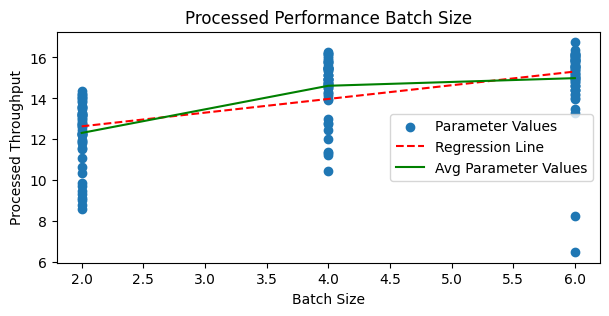

Slope: 0.669
Intercept: 11.297
R-value: 0.562
P-value: 6.9558580009200285e-15
Standard error: 0.078


In [ ]:
### CODING TASK 2d ###

#we will now try the regressions for each parameter against throughput and obtain a slope, intercept, p value and chart
#sci kit learn does not seem to provide the p value directly so we will import another module to calculate the p value which is scipy
#documentation: https://datascience.stackexchange.com/questions/15398/how-to-get-p-value-and-confident-interval-in-logisticregression-with-sklearn
#the above is an old quesiton but the sklearn documentation also does not have a p value calculation showing
#instead there is an f regression which then gives a p value which i am not sure what it is so i will avoid it
#documentation: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html

from scipy import stats

#linear regression for processed performance batch size (ppbs)

ppbs_X = df_processed_performance_batch_size[['Batch Size']].values.reshape(-1, 1)
ppbs_y = df_processed_performance_batch_size['Images Per Second'].values

ppbs_model = LinearRegression()
ppbs_model.fit(ppbs_X, ppbs_y)

ppbs_predictions = ppbs_model.predict(ppbs_X)

ppbs_slope, ppbs_intercept, ppbs_r_value, ppbs_p_value, ppbs_std_err = stats.linregress(ppbs_X.flatten(), ppbs_y)

fig = plt.figure(figsize=(7,3))
plt.scatter(ppbs_X, ppbs_y, label='Parameter Values')
plt.plot(ppbs_X, ppbs_predictions, color='red', linestyle='dashed',label='Regression Line')
plt.plot(df_mean_processed_throughput_batch_size['Batch Size'],
         df_mean_processed_throughput_batch_size['Average Images Per Second'], label='Avg Parameter Values', color='green')
plt.title('Processed Performance Batch Size')
plt.legend()
plt.ylabel('Processed Throughput')
plt.xlabel('Batch Size')
plt.show()

print(f"Slope: {round(ppbs_slope, 3)}") #steepness or rate of change of 2 variables
print(f"Intercept: {round(ppbs_intercept, 3)}") #if indepedant variable is 0 the dependant variable would be this
print(f"R-value: {round(ppbs_r_value, 3)}") #correlation coefficient - strength and direction of linear relationship
print(f"P-value: {ppbs_p_value}") #statistical significance of relationship
print(f"Standard error: {round(ppbs_std_err, 3)}") #the accuracy of measuring the slope

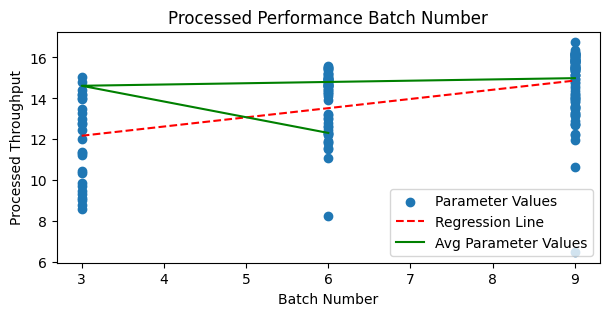

Slope: 0.449
Intercept: 10.828
R-value: 0.517
P-value: 1.9051446541859333e-12
Standard error: 0.059


In [ ]:
#linear regression for processed performance batch number (ppbn)

ppbn_X = df_processed_performance_batch_number[['Batch Number']].values.reshape(-1, 1)
ppbn_y = df_processed_performance_batch_number['Images Per Second'].values

ppbn_model = LinearRegression()
ppbn_model.fit(ppbn_X, ppbn_y)

ppbn_predictions = ppbn_model.predict(ppbn_X)

ppbn_slope, ppbn_intercept, ppbn_r_value, ppbn_p_value, ppbn_std_err = stats.linregress(ppbn_X.flatten(), ppbn_y)

fig = plt.figure(figsize=(7,3))
plt.scatter(ppbn_X, ppbn_y, label='Parameter Values')
plt.plot(ppbn_X, ppbn_predictions, color='red', linestyle='dashed',label='Regression Line')
plt.plot(df_mean_processed_throughput_batch_number['Batch Number'],
         df_mean_processed_throughput_batch_size['Average Images Per Second'], label='Avg Parameter Values', color='green')
plt.title('Processed Performance Batch Number')
plt.legend()
plt.ylabel('Processed Throughput')
plt.xlabel('Batch Number')
plt.show()

print(f"Slope: {round(ppbn_slope, 3)}")
print(f"Intercept: {round(ppbn_intercept, 3)}")
print(f"R-value: {round(ppbn_r_value, 3)}")
print(f"P-value: {ppbn_p_value}")
print(f"Standard error: {round(ppbn_std_err, 3)}")

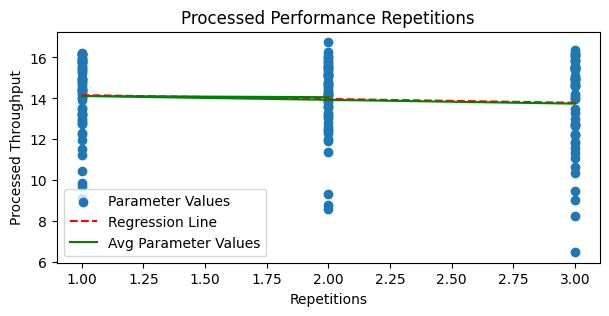

Slope: -0.186
Intercept: 14.347
R-value: -0.078
P-value: 0.323
Standard error: 0.188


In [ ]:
#linear regression for processed performance repetitions (ppr)

ppr_X = df_processed_performance_repetitions[['Repetitions']].values.reshape(-1, 1)
ppr_y = df_processed_performance_repetitions['Images Per Second'].values

ppr_model = LinearRegression()
ppr_model.fit(ppr_X, ppr_y)

ppr_predictions = ppr_model.predict(ppr_X)

ppr_slope, ppr_intercept, ppr_r_value, ppr_p_value, ppr_std_err = stats.linregress(ppr_X.flatten(), ppr_y)

fig = plt.figure(figsize=(7,3))
plt.scatter(ppr_X, ppr_y, label='Parameter Values')
plt.plot(ppr_X, ppr_predictions, color='red', linestyle='dashed',label='Regression Line')
plt.plot(df_mean_processed_throughput_repetitions['Repetitions'],
         df_mean_processed_throughput_repetitions['Average Images Per Second'], label='Avg Parameter Values', color='green')
plt.title('Processed Performance Repetitions')
plt.legend()
plt.ylabel('Processed Throughput')
plt.xlabel('Repetitions')
plt.show()

print(f"Slope: {round(ppr_slope, 3)}")
print(f"Intercept: {round(ppr_intercept, 3)}")
print(f"R-value: {round(ppr_r_value, 3)}")
print(f"P-value: {round(ppr_p_value, 3)}")
print(f"Standard error: {round(ppr_std_err, 3)}")

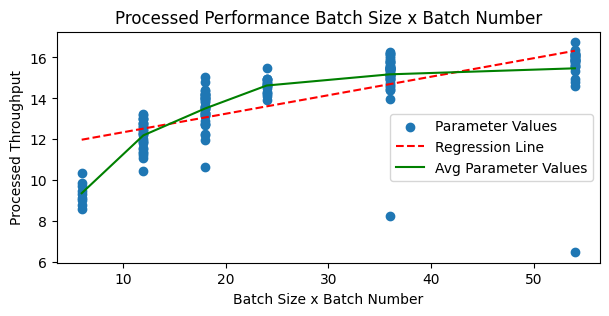

Slope: 0.091
Intercept: 11.439
R-value: 0.697
P-value: 6.796746196305857e-25
Standard error: 0.007


In [ ]:
#linear regression for processed performance batch size times batch number (ppbsbn)

ppbsbn_X = df_processed_performance_batch_size_batch_number_product[['Batch Size x Batch Number']].values.reshape(-1, 1)
ppbsbn_y = df_processed_performance_batch_size_batch_number_product['Images Per Second'].values

ppbsbn_model = LinearRegression()
ppbsbn_model.fit(ppbsbn_X, ppbsbn_y)

ppbsbn_predictions = ppbsbn_model.predict(ppbsbn_X)

ppbsbn_slope, ppbsbn_intercept, ppbsbn_r_value, ppbsbn_p_value, ppbsbn_std_err = stats.linregress(ppbsbn_X.flatten(), ppbsbn_y)

fig = plt.figure(figsize=(7,3))
plt.scatter(ppbsbn_X, ppbsbn_y, label='Parameter Values')
plt.plot(ppbsbn_X, ppbsbn_predictions, color='red', linestyle='dashed',label='Regression Line')
plt.plot(df_mean_processed_throughput_batch_size_batch_number_product['Batch Size x Batch Number'],
         df_mean_processed_throughput_batch_size_batch_number_product['Average Images Per Second'], label='Avg Parameter Values', color='green')
plt.title('Processed Performance Batch Size x Batch Number')
plt.legend()
plt.ylabel('Processed Throughput')
plt.xlabel('Batch Size x Batch Number')
plt.show()

print(f"Slope: {round(ppbsbn_slope, 3)}")
print(f"Intercept: {round(ppbsbn_intercept, 3)}")
print(f"R-value: {round(ppbsbn_r_value, 3)}")
print(f"P-value: {ppbsbn_p_value}")
print(f"Standard error: {round(ppbsbn_std_err, 3)}")

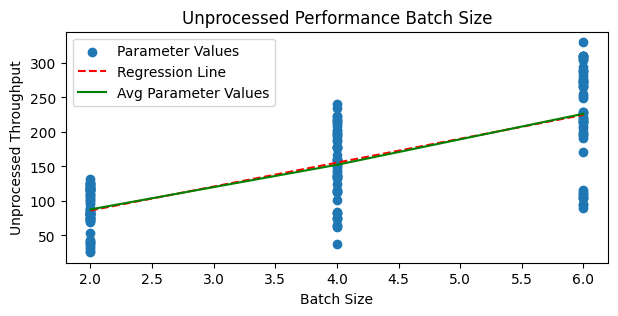

Slope: 34.658
Intercept: 16.812
R-value: 0.73
P-value: 3.108367593969287e-28
Standard error: 2.566


In [ ]:
#linear regression for unprocessed performance batch size (uppbs)

uppbs_X = df_unprocessed_performance_batch_size[['Batch Size']].values.reshape(-1, 1)
uppbs_y = df_unprocessed_performance_batch_size['Images Per Second'].values

uppbs_model = LinearRegression()
uppbs_model.fit(uppbs_X, uppbs_y)

uppbs_predictions = uppbs_model.predict(uppbs_X)

uppbs_slope, uppbs_intercept, uppbs_r_value, uppbs_p_value, uppbs_std_err = stats.linregress(uppbs_X.flatten(), uppbs_y)

fig = plt.figure(figsize=(7,3))
plt.scatter(uppbs_X, uppbs_y, label='Parameter Values')
plt.plot(uppbs_X, uppbs_predictions, color='red', linestyle='dashed',label='Regression Line')
plt.plot(df_mean_unprocessed_throughput_batch_size['Batch Size'],
         df_mean_unprocessed_throughput_batch_size['Average Images Per Second'], label='Avg Parameter Values', color='green')
plt.title('Unprocessed Performance Batch Size')
plt.legend()
plt.ylabel('Unprocessed Throughput')
plt.xlabel('Batch Size')
plt.show()

print(f"Slope: {round(uppbs_slope, 3)}")
print(f"Intercept: {round(uppbs_intercept, 3)}")
print(f"R-value: {round(uppbs_r_value, 3)}")
print(f"P-value: {uppbs_p_value}")
print(f"Standard error: {round(uppbs_std_err, 3)}")

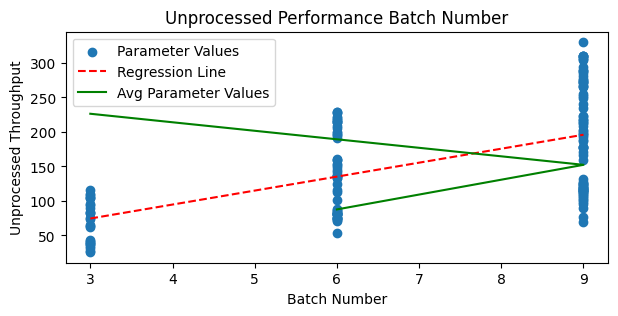

Slope: 20.234
Intercept: 13.804
R-value: 0.584
P-value: 3.6656138612092686e-16
Standard error: 2.226


In [ ]:
#linear regression for unprocessed performance batch number (uppbn)

uppbn_X = df_unprocessed_performance_batch_number[['Batch Number']].values.reshape(-1, 1)
uppbn_y = df_unprocessed_performance_batch_number['Images Per Second'].values

uppbn_model = LinearRegression()
uppbn_model.fit(uppbn_X, uppbn_y)

uppbn_predictions = uppbn_model.predict(uppbn_X)

uppbn_slope, uppbn_intercept, uppbn_r_value, uppbn_p_value, uppbn_std_err = stats.linregress(uppbn_X.flatten(), uppbn_y)

fig = plt.figure(figsize=(7,3))
plt.scatter(uppbn_X, uppbn_y, label='Parameter Values')
plt.plot(uppbn_X, uppbn_predictions, color='red', linestyle='dashed',label='Regression Line')
plt.plot(df_mean_unprocessed_throughput_batch_number['Batch Number'],
         df_mean_unprocessed_throughput_batch_size['Average Images Per Second'], label='Avg Parameter Values', color='green')
plt.title('Unprocessed Performance Batch Number')
plt.legend()
plt.ylabel('Unprocessed Throughput')
plt.xlabel('Batch Number')
plt.show()

print(f"Slope: {round(uppbn_slope, 3)}")
print(f"Intercept: {round(uppbn_intercept, 3)}")
print(f"R-value: {round(uppbn_r_value, 3)}")
print(f"P-value: {uppbn_p_value}")
print(f"Standard error: {round(uppbn_std_err, 3)}")

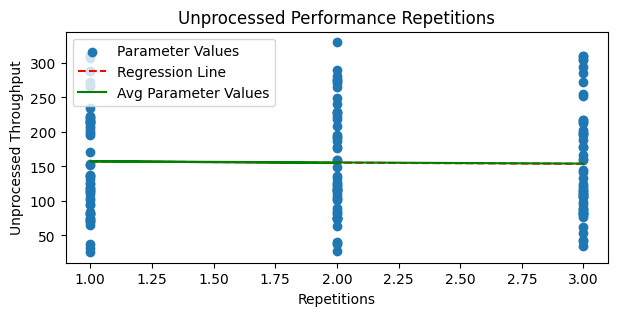

Slope: -1.673
Intercept: 158.791
R-value: -0.018
P-value: 0.824
Standard error: 7.506


In [ ]:
#linear regression for unprocessed performance repetitions (uppr)

uppr_X = df_unprocessed_performance_repetitions[['Repetitions']].values.reshape(-1, 1)
uppr_y = df_unprocessed_performance_repetitions['Images Per Second'].values

uppr_model = LinearRegression()
uppr_model.fit(uppr_X, uppr_y)

uppr_predictions = uppr_model.predict(uppr_X)

uppr_slope, uppr_intercept, uppr_r_value, uppr_p_value, uppr_std_err = stats.linregress(uppr_X.flatten(), uppr_y)

fig = plt.figure(figsize=(7,3))
plt.scatter(uppr_X, uppr_y, label='Parameter Values')
plt.plot(uppr_X, uppr_predictions, color='red', linestyle='dashed',label='Regression Line')
plt.plot(df_mean_unprocessed_throughput_repetitions['Repetitions'],
         df_mean_unprocessed_throughput_repetitions['Average Images Per Second'], label='Avg Parameter Values', color='green')
plt.title('Unprocessed Performance Repetitions')
plt.legend()
plt.ylabel('Unprocessed Throughput')
plt.xlabel('Repetitions')
plt.show()

print(f"Slope: {round(uppr_slope, 3)}")
print(f"Intercept: {round(uppr_intercept, 3)}")
print(f"R-value: {round(uppr_r_value, 3)}")
print(f"P-value: {round(uppr_p_value, 3)}")
print(f"Standard error: {round(uppr_std_err, 3)}")

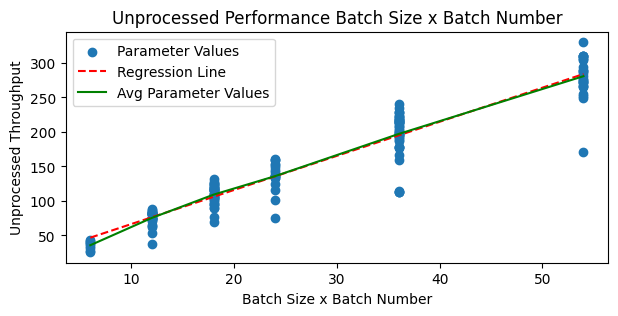

Slope: 4.939
Intercept: 17.139
R-value: 0.953
P-value: 3.221420265355257e-85
Standard error: 0.123


In [ ]:
#linear regression for unprocessed performance batch size times batch number (uppbsbn)

uppbsbn_X = df_unprocessed_performance_batch_size_batch_number_product[['Batch Size x Batch Number']].values.reshape(-1, 1)
uppbsbn_y = df_unprocessed_performance_batch_size_batch_number_product['Images Per Second'].values

uppbsbn_model = LinearRegression()
uppbsbn_model.fit(uppbsbn_X, uppbsbn_y)

uppbsbn_predictions = uppbsbn_model.predict(uppbsbn_X)

uppbsbn_slope, uppbsbn_intercept, uppbsbn_r_value, uppbsbn_p_value, uppbsbn_std_err = stats.linregress(uppbsbn_X.flatten(), uppbsbn_y)

fig = plt.figure(figsize=(7,3))
plt.scatter(uppbsbn_X, uppbsbn_y, label='Parameter Values')
plt.plot(uppbsbn_X, uppbsbn_predictions, color='red', linestyle='dashed',label='Regression Line')
plt.plot(df_mean_unprocessed_throughput_batch_size_batch_number_product['Batch Size x Batch Number'],
         df_mean_unprocessed_throughput_batch_size_batch_number_product['Average Images Per Second'], label='Avg Parameter Values', color='green')
plt.title('Unprocessed Performance Batch Size x Batch Number')
plt.legend()
plt.ylabel('Unprocessed Throughput')
plt.xlabel('Batch Size x Batch Number')
plt.show()

print(f"Slope: {round(uppbsbn_slope, 3)}")
print(f"Intercept: {round(uppbsbn_intercept, 3)}")
print(f"R-value: {round(uppbsbn_r_value, 3)}")
print(f"P-value: {uppbsbn_p_value}")
print(f"Standard error: {round(uppbsbn_std_err, 3)}")

In [ ]:
#creating a big table of all the results

linear_regression_results = [
    {'Parameter': 'Processed Batch Size', 'Slope': ppbs_slope,
     'Intercept': ppbs_intercept, 'R-value': ppbs_r_value, 'P-value': ppbs_p_value, 'Std Error': ppbs_std_err},

    {'Parameter': 'Processed Batch Number', 'Slope': ppbn_slope,
     'Intercept': ppbn_intercept, 'R-value': ppbn_r_value, 'P-value': ppbn_p_value, 'Std Error': ppbn_std_err},

    {'Parameter': 'Processed Repetitions', 'Slope': ppr_slope,
     'Intercept': ppr_intercept, 'R-value': ppr_r_value, 'P-value': ppr_p_value, 'Std Error': ppr_std_err},

    {'Parameter': 'Processed Batch Size x Batch Number', 'Slope': ppbsbn_slope,
     'Intercept': ppbsbn_intercept, 'R-value': ppbsbn_r_value, 'P-value': ppbsbn_p_value, 'Std Error': ppbsbn_std_err},

    {'Parameter': 'Unprocessed Batch Size', 'Slope': uppbs_slope,
     'Intercept': uppbs_intercept, 'R-value': uppbs_r_value, 'P-value': uppbs_p_value, 'Std Error': uppbs_std_err},

    {'Parameter': 'Unprocessed Batch Number', 'Slope': uppbn_slope,
     'Intercept': uppbn_intercept, 'R-value': uppbn_r_value, 'P-value': uppbn_p_value, 'Std Error': uppbn_std_err},

    {'Parameter': 'Unprocessed Repetitions', 'Slope': uppr_slope,
     'Intercept': uppr_intercept, 'R-value': uppr_r_value, 'P-value': uppr_p_value, 'Std Error': uppr_std_err},

    {'Parameter': 'Unprocessed Batch Size x Batch Number', 'Slope': uppbsbn_slope,
     'Intercept': uppbsbn_intercept, 'R-value': uppbsbn_r_value, 'P-value': uppbsbn_p_value, 'Std Error': uppbsbn_std_err}
]

df_linear_regression_results = pd.DataFrame(linear_regression_results)

df_linear_regression_results

Parameter      Slope   Intercept   R-value  \
0                   Processed Batch Size   0.669380   11.296686  0.562240   
1                 Processed Batch Number   0.449395   10.828441  0.516866   
2                  Processed Repetitions  -0.186191   14.346586 -0.078195   
3    Processed Batch Size x Batch Number   0.090555   11.438651  0.697114   
4                 Unprocessed Batch Size  34.658317   16.811811  0.729943   
5               Unprocessed Batch Number  20.234375   13.804457  0.583542   
6                Unprocessed Repetitions  -1.672887  158.790853 -0.017616   
7  Unprocessed Batch Size x Batch Number   4.939494   17.139257  0.953463   

        P-value  Std Error  
0  6.955858e-15   0.077836  
1  1.905145e-12   0.058843  
2  3.226310e-01   0.187667  
3  6.796746e-25   0.007363  
4  3.108368e-28   2.565675  
5  3.665614e-16   2.226169  
6  8.239234e-01   7.506214  
7  3.221420e-85   0.123487

In [3]:
#NOTE THAT BELOW DISCUSSION QUESTIONS ARE ANSWERED IN THE REPORT

#Perform a linear regression (e.g. using scikit-learn) over the values for each parameter
#and for the two cases (reading from image files/reading TFRecord files).
#List a table with the output and interpret the results in terms of the effects of overall.

#Also, plot the output values, the averages per parameter value and the regression lines for each parameter
#and for the product of batch_size and batch_number

#Discuss the implications of this result for applications like large-scale machine learning.
#Keep in mind that cloud data may be stored in distant physical locations.
#Use the numbers provided in the PDF latency-numbers document available on Moodle or here for your arguments.

#How is the observed behaviour similar or different from what you’d expect from a single machine?
#Why would cloud providers tie throughput to capacity of disk resources?

#By parallelising the speed test we are making assumptions about the limits of the bucket reading speeds.
#See here for more information. Discuss, what we need to consider in speed tests in parallel on the cloud,
#which bottlenecks we might be identifying, and how this relates to your results.

#Discuss to what extent linear modelling reflects the effects we are observing.
#Discuss what could be expected from a theoretical perspective and what can be useful in practice.

# Section 3. Theoretical discussion

## Task 3: Discussion in context. (24%)

In this task we refer an idea that is introduced in this paper:
-	Alipourfard, O., Liu, H. H., Chen, J., Venkataraman, S., Yu, M., & Zhang, M. (2017). [Cherrypick: Adaptively unearthing the best cloud configurations for big data analytics.](https://people.irisa.fr/Davide.Frey/wp-content/uploads/2018/02/cherrypick.pdf). In USENIX NSDI  17 (pp. 469-482).

Alipourfard et al (2017) introduce  the prediction an optimal or near-optimal cloud configuration for a given compute task.

### 3a)	Contextualise

Relate the previous tasks and the results to this concept. (It is not necessary to work through the full details of the paper, focus just on the main ideas). To what extent and under what conditions do the concepts and techniques in the paper apply to the task in this coursework? (12%)

### 3b)	Strategise

Define - as far as possible - concrete strategies for different application scenarios (batch, stream) and discuss the general relationship with the concepts above. (12%)

Provide the answers to these questions in your report.


In [4]:
#NOTE THAT TASK 3 IS ANSWERED IN THE REPORT

## Final cleanup

Once you have finshed the work, you can delete the buckets, to stop incurring cost that depletes your credit.

In [ ]:
#!gsutil -m rm -r $BUCKET/* # Empty your bucket
#!gsutil rb $BUCKET # delete the bucket